<a href="https://colab.research.google.com/github/taro470/l5g_python/blob/main/soturon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 日本語をタイトルやラベルに使うためのライブラリインストール

In [2]:
!pip install japanize-matplotlib
# !pip install pyshark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=bf1420d21ce95c124815f3e99316084610a6ade80b271be62d4dde596fc44654
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


# 通信断時間の自動計算と分布図表示


[INFO] Processing: 20251031_062300.csv
[INFO] 検出通信断 >= 0.08s: 1 件
       min=0.144s  median=0.144s  max=0.144s

[INFO] Processing: 20251031_070340.csv
[INFO] 検出通信断 >= 0.08s: 1 件
       min=0.872s  median=0.872s  max=0.872s

[INFO] 総通信断数: 2


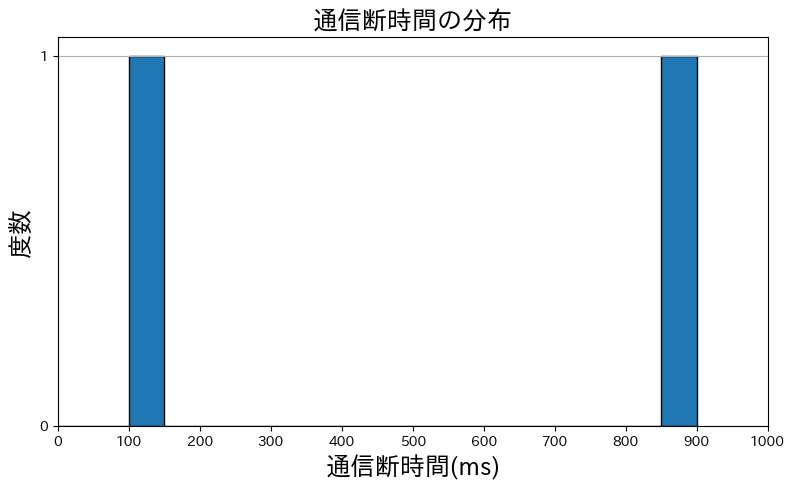

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
import glob
from matplotlib.ticker import MaxNLocator
# import os
# import sys
# from pathlib import Path

# ====== 設定（ ==========================================
CSV_GLOB = "*.csv"  # CSVの場所（例）
THRESHOLD_SEC = 0.08           # 通信断とみなす閾値（秒）
BIN_WIDTH = 0.05                # ヒストグラムのビン幅（秒）
# ========================================================

files = sorted(glob.glob(CSV_GLOB))

outage_durations = []

for f in files:
    print(f"\n[INFO] Processing: {f}")
    try:
        df = pd.read_csv(f)
    except Exception as e:
        print(f"[ERROR] 読み込み失敗: {e}")
        continue

    # 列名の前後スペース除去
    df.columns = [c.strip() for c in df.columns]

    # Time列の確認と代替候補
    if "Time" not in df.columns:
        print(f"[WARN] 'Time' 列がありません。列一覧: {df.columns.tolist()}")
        for alt in ["time", "timestamp", "Time[s]", "Seconds", "epoch", "ts"]:
            if alt in df.columns:
                df = df.rename(columns={alt: "Time"})
                print(f"[INFO] 代替列 '{alt}' を Time として使用します。")
                break
        else:
            print("[WARN] スキップします（Time列が見つからない）。")
            continue


    # 連続パケットの間隔
    df["delta"] = df["Time"].diff()

    # 閾値以上を通信断と判定
    outages = df.loc[df["delta"] >= THRESHOLD_SEC, "delta"].tolist()
    print(f"[INFO] 検出通信断 >= {THRESHOLD_SEC}s: {len(outages)} 件")
    if outages:
        print(f"       min={min(outages):.3f}s  median={np.median(outages):.3f}s  max={max(outages):.3f}s")

    outage_durations.extend(outages)

print(f"\n[INFO] 総通信断数: {len(outage_durations)}")

# ビン設定（データに応じて上限を自動調整）
if outage_durations:
    mx = max(outage_durations)
    # 上限がビン幅の整数倍になるように調整
    upper = (np.floor(mx / BIN_WIDTH) + 1) * BIN_WIDTH
    bins = np.arange(0, upper + BIN_WIDTH, BIN_WIDTH)

#------外れ値処理

#------


plt.figure(figsize=(8, 5))
plt.hist(outage_durations, bins=bins, edgecolor="black")
plt.xlabel("通信断時間(ms)", fontsize=18)
plt.ylabel("度数", fontsize=18)
plt.title("通信断時間の分布", fontsize=18)
plt.grid(True, axis="y")
plt.tight_layout()
plt.xlim(0,1)

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# x軸の範囲
x_min, x_max = plt.xlim()
xticks = np.arange(0, x_max+0.1, 0.1)
plt.xticks(xticks, [f"{int(x*1000)}" for x in xticks])

plt.show()


# ①pingのプロット（3回分同時に表示）

## 訂正前

104.0
111.0
121.0


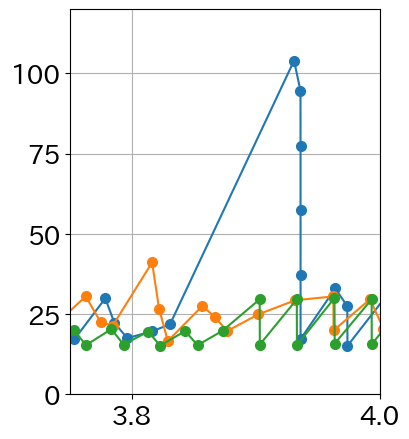

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib
from datetime import datetime, timezone, timedelta

# 読み込むJSONファイルのリスト（必要に応じてファイル名を変更）
json_files = [                   # メディアセンター内(pRadio→RU#3)
    "20250205203819_ping.json",
    # "20250205204050_ping.json",
    # "20250205204300_ping.json"
    "20250209195705_ping.json",
    "20250209201710_ping.json"
]
json_files = [                   # メディアセンター内(RU#3→pRadio)
    "20250205212130_ping.json",
    "20250205212230_ping.json",
   "20250205212330_ping.json"
    # "20250209195750_ping.json",
]
json_files = [         # DU#3>>>DU#2
    "20250208172725_ping.json",
    "20250208172940_ping.json",
    "20250208173315_ping.json"
]
json_files = [         # DU#2>>>DU#3
    "20250208174230_ping.json",
    "20250208174325_ping.json",
    "20250208174420_ping.json"
]
json_files = [         # DU#1>>>DU#2
    "20250209171425_ping.json",
    "20250209165850_ping.json",
    "20250209170140_ping.json"
]
json_files = [         # DU#2>>>DU#1
    "20250209165515_ping.json",
    "20250209170855_ping.json",
    "20250209171605_ping.json"
]

# プロット用のラベル（ファイル毎の識別名）
labels = ["1回目", "2回目", "3回目"]

# JST（日本標準時）のタイムゾーン設定
jst = timezone(timedelta(hours=9))

# グラフの作成
plt.figure(figsize=(4, 5))

# 各ファイルについて処理
for file, label in zip(json_files, labels):
    # JSONファイルの読み込み
    with open(file, "r") as f:
        data = json.load(f)

    # responsesからタイムスタンプとtime_msを抽出
    responses = data.get("responses", [])

    # タイムスタンプをdatetimeオブジェクトに変換
    timestamps = [
        datetime.fromtimestamp(entry["timestamp"], jst)
        for entry in responses if "timestamp" in entry and "time_ms" in entry
    ]
    time_ms = [
        entry["time_ms"]
        for entry in responses if "timestamp" in entry and "time_ms" in entry
    ]

    # 相対秒表示とするため、各データの最初のタイムスタンプを基準にする
    if timestamps:
        t0 = min(timestamps)
        x_seconds = [(t - t0).total_seconds() for t in timestamps]
    else:
        x_seconds = []

   # ここで、相対秒(x_seconds)が10以下、または30以上のデータを削除（除外）する
    filtered = [(xs, tm) for xs, tm in zip(x_seconds, time_ms) if 10 < xs < 30]
    if filtered:
        x_seconds, time_ms = zip(*filtered)
        x_seconds = list(x_seconds)
        time_ms = list(time_ms)
    else:
        # データがない場合は空リストに
        x_seconds, time_ms = [], []

    # x軸の値を10秒分減算して表示（例：元が11秒なら1秒として表示）
    x_seconds = [x - 10 for x in x_seconds]

    # グラフへプロット
    plt.plot(x_seconds, time_ms, marker="o", linestyle="-", markersize=7, label=label)

    print(max(time_ms))

# グラフの設定
# plt.title("RTT（メディアセンター内）")
# plt.xlabel("経過時間 (秒)")
plt.xlim(3.75,4)
# plt.xlim(14.1,14.3)
# plt.ylabel("伝送遅延(ms)")
plt.ylim(0,120)
plt.grid(True)
# plt.legend()
plt.rcParams["font.size"] = 25

# x軸の目盛り設定：5秒刻みで表示し、ラベルは小数点以下2桁まで表示
ax = plt.gca()
# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.show()


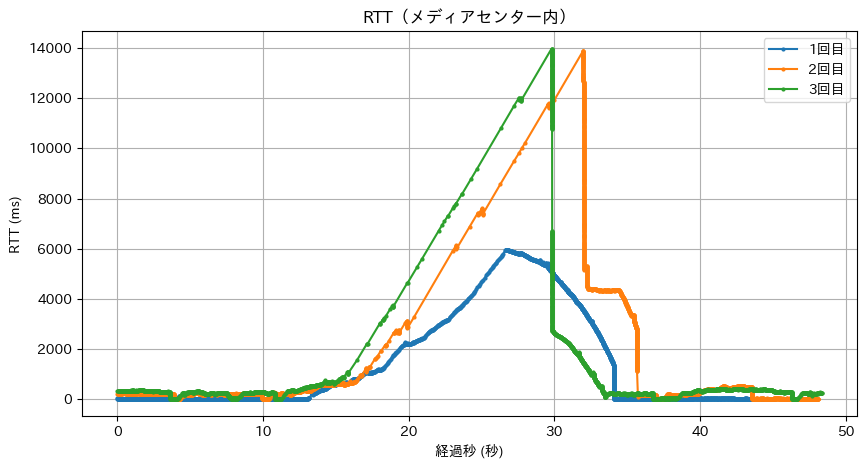

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib
from datetime import datetime, timezone, timedelta

# 読み込むJSONファイルのリスト（必要に応じてファイル名を変更）
json_files = [                   # メディアセンター内(pRadio→RU#3)
    "20250205203819_ping.json",
    "20250205204050_ping.json",  # 例: 2つ目のファイル
    "20250205204300_ping.json"   # 例: 3つ目のファイル
]
# json_files = [                   # メディアセンター内(RU#3→pRadio)
#     "20250205212130_ping.json",
#     "20250205212230_ping.json",  # 例: 2つ目のファイル
#     "20250205212330_ping.json"   # 例: 3つ目のファイル
# ]

# 訂正後（100M）
json_files = [
    "20250320101943_ping.json",
    "20250320102139_ping.json",
    "20250320102335_ping.json"]





# UDP_40M
json_files = [
    "20250320101943_ping.json",
    "20250320102139_ping.json",
    "20250320102335_ping.json"]














# プロット用のラベル（ファイル毎の識別名）
labels = ["1回目", "2回目", "3回目"]

# JST（日本標準時）のタイムゾーン設定
jst = timezone(timedelta(hours=9))

# グラフの作成
plt.figure(figsize=(10, 5))

# 各ファイルについて処理
for file, label in zip(json_files, labels):
    # JSONファイルの読み込み
    with open(file, "r") as f:
        data = json.load(f)

    # responsesからタイムスタンプとtime_msを抽出
    responses = data.get("responses", [])

    # タイムスタンプをdatetimeオブジェクトに変換
    timestamps = [
        datetime.fromtimestamp(entry["timestamp"], jst)
        for entry in responses if "timestamp" in entry and "time_ms" in entry
    ]
    time_ms = [
        entry["time_ms"]
        for entry in responses if "timestamp" in entry and "time_ms" in entry
    ]

    # 相対秒表示とするため、各ファイルの最初のタイムスタンプを基準にする
    if timestamps:
        t0 = min(timestamps)
        x_seconds = [(t - t0).total_seconds() for t in timestamps]
    else:
        x_seconds = []

    # ここで、相対秒(x_seconds)が△以下、または×以上のデータを削除（除外）する
    filtered = [(xs, tm) for xs, tm in zip(x_seconds, time_ms) if 0 < xs < 30]
    if filtered:
        x_seconds, time_ms = zip(*filtered)
        x_seconds = list(x_seconds)
        time_ms = list(time_ms)
    else:
        # データがない場合は空リストに
        x_seconds, time_ms = [], []

    # x軸の値を10秒分減算して表示（例：元が11秒なら1秒として表示）
    x_seconds = [x - 10 for x in x_seconds]

    # グラフへプロット
    plt.plot(x_seconds, time_ms, marker="o", linestyle="-", markersize=2, label=label)

# グラフの設定
plt.title("RTT（メディアセンター内）")
plt.xlabel("経過秒 (秒)")
# plt.xlim(0,20)
plt.ylabel("RTT (ms)")
# plt.ylim(0,165)
plt.grid(True)
plt.legend()

# x軸の目盛り設定：5秒刻みで表示し、ラベルは小数点以下2桁まで表示
# ax = plt.gca()
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.show()


## 訂正後

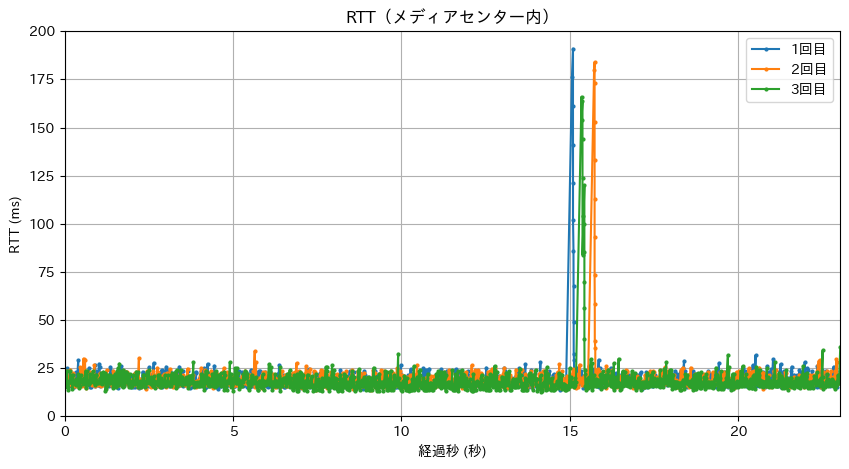

In [ ]:
import json
import matplotlib.pyplot as plt
import japanize_matplotlib
from datetime import datetime, timedelta, timezone



# JSONファイルリスト
json_files = [
    # interCU2DU3_100
    # "20250320101943_ping.json",
    # "20250320102139_ping.json",
    # "20250320102335_ping.json"

    # interCU2DU3_40
    # "20250320180332_ping.json",
    # "20250320180546_ping.json",
    # "20250320180734_ping.json"

    # DU3>>DU2_40
    "20250320175147_ping.json",
    "20250320175419_ping.json",
    "20250320175555_ping.json"

    # DU2>>DU3_40
    # "20250321071733_ping.json",
    # "20250321071931_ping.json",
    # "20250321153754_ping.json"

    # DU2>>DU1_40
    # "20250321114038_ping.json",
    # "20250321114321_ping.json",
    # "20250321114620_ping.json"

    # DU1>>DU2_40
    # "20250321114957_ping.json",
    # "20250321115246_ping.json",
    # "20250321115506_ping.json"
]



# プロット用のラベル（ファイル毎の識別名）
labels = ["1回目", "2回目", "3回目"]

# JST（日本標準時）のタイムゾーン設定
jst = timezone(timedelta(hours=9))

# 各ファイルごとの timestamp の範囲を指定（None にすると全範囲）
time_ranges = {
    "20250320101943_ping.json": (
        datetime(2025, 3, 20, 10, 19, 50, 216655, tzinfo=jst),
        datetime(2025, 3, 20, 10, 20, 1, 225520, tzinfo=jst)
    ),
    "20250320102139_ping.json": (
        datetime(2025, 3, 20, 10, 21, 49, 999789, tzinfo=jst),
        datetime(2025, 3, 20, 10, 22, 0, 571455, tzinfo=jst)
    ),
    "20250320102335_ping.json": (
        datetime(2025, 3, 20, 10, 23, 45, 336665, tzinfo=jst),
        datetime(2025, 3, 20, 10, 23, 56, 297697, tzinfo=jst)
    ),
    # interCU2DU3_40
    "20250320180332_ping.json": (
        datetime(2025, 3, 20, 12, 24, 40, 244318, tzinfo=jst),
        None
    ),
    "20250320180546_ping.json": (
        datetime(2025, 3, 20, 18, 6, 0, 244583, tzinfo=jst),
        # datetime(2025, 3, 20, 12, 27, 45, 546911, tzinfo=jst)
        None
    ),
    "20250320180734_ping.json": (
        datetime(2025, 3, 20, 18, 7, 45, 66956, tzinfo=jst),
        # datetime(2025, 3, 20, 12, 33, 47, 46664, tzinfo=jst)
        None
    ),
    # DU3DU2_40(失敗)
    "20250320123759_ping.json": (
        datetime(2025, 3, 20, 12, 38, 6, 754611, tzinfo=jst),
        datetime(2025, 3, 20, 12, 38, 29, 877912, tzinfo=jst)
    ),
    "20250320123954_ping.json": (
        datetime(2025, 3, 20, 12, 40, 0, 347857, tzinfo=jst),
        datetime(2025, 3, 20, 12, 40, 23, 636420, tzinfo=jst)
    ),
    "20250320124120_ping.json": (
        datetime(2025, 3, 20, 12, 41, 30, 199479, tzinfo=jst),
        datetime(2025, 3, 20, 12, 41, 53, 588604, tzinfo=jst)
    ),
    # DU3DU2_40(成功)
    "20250320175147_ping.json": (
        datetime(2025, 3, 20, 17, 51, 55, 403634, tzinfo=jst),
        datetime(2025, 3, 20, 17, 52, 18, 337897, tzinfo=jst)
    ),
    "20250320175419_ping.json": (
        datetime(2025, 3, 20, 17, 54, 30, 124033, tzinfo=jst),
        datetime(2025, 3, 20, 17, 54, 53, 569019, tzinfo=jst)
    ),
    "20250320175555_ping.json": (
        datetime(2025, 3, 20, 17, 56, 5, 100936, tzinfo=jst),
        datetime(2025, 3, 20, 17, 56, 28, 529717, tzinfo=jst)
    ),
    # DU2DU3_40
    "20250321071733_ping.json": (
        # None,
        datetime(2025, 3, 21, 7, 17, 45, 20697, tzinfo=jst),
        datetime(2025, 3, 21, 7, 18, 8, 401013, tzinfo=jst)
    ),
    "20250321071931_ping.json": (
        datetime(2025, 3, 21, 7, 19, 39, 950731, tzinfo=jst)
        ,datetime(2025, 3, 21, 7, 20, 3, 540052, tzinfo=jst)
    ),
    # "20250321153754_ping.json": (
    #     datetime(2025, 3, 21, 7, 21, 40, 102148, tzinfo=jst)
    #     ,datetime(2025, 3, 21, 7, 22, 3, 501744, tzinfo=jst)
    # ),
    # DU2DU1_40
    "20250321114038_ping.json": (
        # None,
        datetime(2025, 3, 21, 11, 40, 45, 170496, tzinfo=jst),
        datetime(2025, 3, 21, 11, 41, 15, 586121, tzinfo=jst)
    ),
    "20250321114321_ping.json": (
        datetime(2025, 3, 21, 11, 43, 30, 228154, tzinfo=jst)
        ,datetime(2025, 3, 21, 11, 44, 0, 358078, tzinfo=jst)
    ),
    "20250321114620_ping.json": (
        datetime(2025, 3, 21, 11, 46, 30, 238993, tzinfo=jst)
        ,datetime(2025, 3, 21, 11, 47, 00, 339050, tzinfo=jst)
    ),
    # DU1DU2_40
    "20250321114957_ping.json": (
        # None,
        datetime(2025, 3, 21, 11, 50, 10, 1711, tzinfo=jst),
        datetime(2025, 3, 21, 11, 50, 40, 373524, tzinfo=jst)
    ),
    "20250321115246_ping.json": (
        datetime(2025, 3, 21, 11, 52, 55, 158844, tzinfo=jst)
        ,datetime(2025, 3, 21, 11, 53, 25, 308783, tzinfo=jst)
    ),
    "20250321115506_ping.json": (
        datetime(2025, 3, 21, 11, 55, 14, 566477, tzinfo=jst)
        ,datetime(2025, 3, 21, 11, 55, 45, 4825, tzinfo=jst)
    ),
}



# グラフの作成
plt.figure(figsize=(10, 5))

# 各ファイルについて処理
for file, label in zip(json_files, labels):
    # JSONファイルの読み込み
    with open(file, "r") as f:
        data = json.load(f)

    # responses から timestamp と time_ms を抽出
    responses = data.get("responses", [])

    # ファイルごとの範囲を取得（デフォルトは None）
    start_time, end_time = time_ranges.get(file, (None, None))

    # タイムスタンプを datetime オブジェクトに変換し、範囲内のデータのみ抽出
    timestamps = []
    time_ms = []

    for entry in responses:
        if "timestamp" in entry and "time_ms" in entry:
            ts = datetime.fromtimestamp(entry["timestamp"], jst)

            # 指定範囲内のデータのみ取得
            if (start_time is None or ts >= start_time) and (end_time is None or ts <= end_time):
                timestamps.append(ts)
                time_ms.append(entry["time_ms"])

    # 相対秒表示とするため、各ファイルの最初のタイムスタンプを基準にする
    if timestamps:
        t0 = min(timestamps)
        x_seconds = [(t - t0).total_seconds() for t in timestamps]
    else:
        x_seconds = []

    # グラフへプロット
    plt.plot(x_seconds, time_ms, marker="o", linestyle="-", markersize=2, label=label)

# グラフの設定
plt.title("RTT（メディアセンター内）")
plt.xlabel("経過秒 (秒)")
plt.xlim(0,23)
plt.ylabel("RTT (ms)")
plt.ylim(0,200)
plt.grid(True)
plt.legend()

plt.show()


# ②パケット送受信数の変化プロット

## １つずつ表示

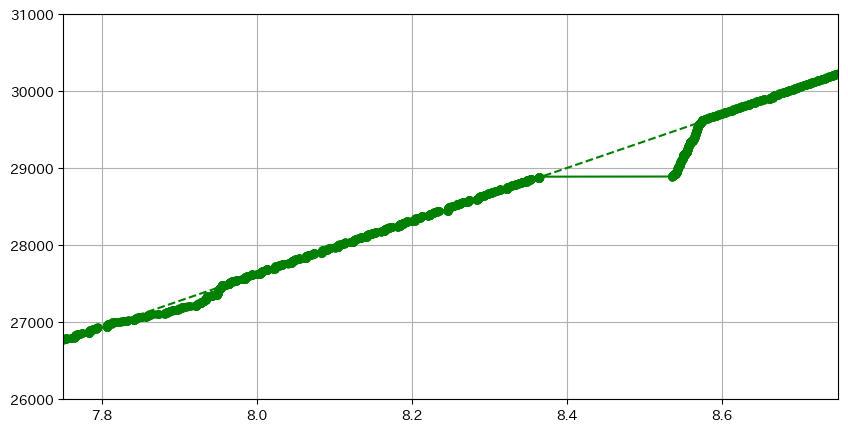

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np  # 目盛り調整のために追加
import matplotlib.ticker as ticker

csv_files = "intraCU_2DU3_3.csv"
# "0206185110.csv"
# "0205184125.csv"
# "0206190505.csv"

# "0209193955.csv"
# "0209194540.csv"
# "0209194825.csv"

# "0208175935.csv"
# "0208181650.csv"
# "0208182110.csv"

# "0208181405.csv"
# "0208181910.csv"
# "0208182325.csv"

# "0209193620.csv"
# "0209193125.csv"
# "0209193400.csv"

# "0209172350.csv"# DU#2>>>DU#1
# "0209173035.csv"
# "0209173940.csv"
#   # DU#1>>>DU#2
# "0209172705.csv"
# "0209173525.csv"
# "0209174235.csv"


# CSVファイルの読み込み
df = pd.read_csv(csv_files)

# "No." を 1 から始まる連番に変更
df["No."] = range(1, len(df) + 1)

# "Time" データを 0 秒から始まるように調整
df["Time"] = df["Time"] - df["Time"].min()

# グラフの作成
plt.figure(figsize=(10, 5))
# plt.plot(df["Time"], df["No."], marker="o", linestyle="-", markersize=5, label="1回目", color='#377eb8')
# plt.plot(df["Time"], df["No."], marker="o", linestyle="-", markersize=5, label="2回目", color='orange')
plt.plot(df["Time"], df["No."], marker="o", linestyle="-", markersize=5, label="3回目", color='green')


# **横軸の目盛りを細かく設定（0.5秒間隔）**
# plt.xticks(np.arange(10, 20, 0.5), rotation=45, ha="right")  # 0.5秒ごとにし、ラベルを斜めに


# グラフの設定
# plt.title("時間経過による累積受信パケット数の推移")
# plt.xlabel("時間経過 (s)")
# plt.ylabel("累積受信パケット数")
ax = plt.gca()
plt.xlim(7.75,8.75)
plt.ylim(26000,31000)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.grid(True)
# plt.legend()


slope_num = (40000000/(1448*8))
plt.axline((0, 0), slope=slope_num, color='green', linestyle='--')

# グラフの表示
plt.show()

## 重ねて表示

### 卒論時データ

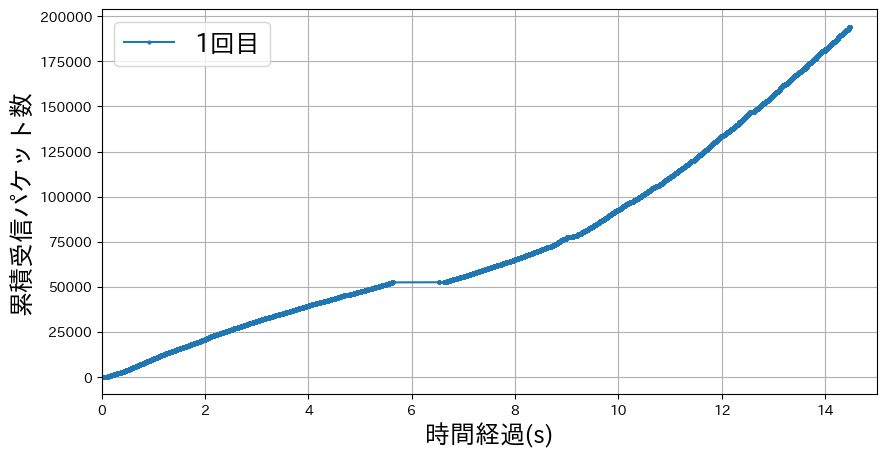

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np  # 目盛り調整のために追加

# 読み込むCSVファイルのリスト（必要に応じてファイル名を変更）
csv_files = [         # pRadio>>>DU3
    # "0206185110.csv",
    # "0205184125.csv",
    # "0206190505.csv"
    # DU3>>>pRadio
    # "0209193955.csv",
    # "0209194540.csv",
    # "0209194825.csv"
    # DU#2>>>DU#3
    # "0208175935.csv",
    # "0208181650.csv",
    # "0208182110.csv"
    # DU#3>>>DU#2
    # "0208181405.csv",
    # "0208181910.csv",
    # "0208182325.csv"
   # DU#2>>>DU#3 2回目
    # "0209193620.csv",
    # "0209193125.csv",
    # "0209193400.csv"
   # DU#2>>>DU#1
    # "0209172350.csv",
    # "0209173035.csv",
    # "0209173940.csv"
   # DU#1>>>DU#2
  #   "0209172705.csv",
  #  "0209173525.csv",
  #   # "0209191425.csv",
  #   "0209174235.csv"

# 訂正(100M)
   # pRadio>>>DU3
    # "interCU_2DU3_iperf_1.csv",
    # "interCU_2DU3_iperf_2.csv",
    # "interCU_2DU3_iperf_3.csv"

    # pRadio>>DU3 40
    # "interCU2DU3_iperf_40_1.csv",
    # "interCU2DU3_iperf_40_2.csv",
    # "interCU2DU3_iperf_40_3.csv"

    # DU3>>DU2 40
    # "intraCU2DU2_iperf_40_1.csv",
    # "intraCU2DU2_iperf_40_2.csv",
    # "intraCU2DU2_iperf_40_3.csv",
    # DU2>>DU3 40
    # "intraCU_2DU3_1.csv",
    # "intraCU_2DU3_2.csv",
    # "intraCU_2DU3_3.csv",
    # # DU2>>DU1 40
    # "intraDU2DU1_1.csv",
    # "intraDU2DU1_2.csv",
    # "intraDU2DU1_3.csv",
    # DU1>>DU2 40
    # "intraDU2DU2_1.csv",
    # "intraDU2DU2_2.csv",
    # "intraDU2DU2_3.csv",



    # DU1>>DU2 40
    # "20250529_101325.csv",
    # "20250529_101510.csv",
    # "20250529_101620.csv",

    # TCP
    # "20250529_100040.csv", #deault
    # "20250529_100350.csv", #reno
    # "20250529_100520.csv"  #cubic

    # UDP20
    # "20250529_100725.csv",
    # "20250529_100858.csv",
    # "20250529_101033.csv",
    # "20250529_160835.csv",
    # "20250529_161010.csv"

    # UDP30
    # "20250529_161140.csv",
    # "20250529_161245.csv",
    # "20250529_161345.csv",
    # "20250529_161435.csv",
    # "20250529_161530.csv"

    # UDP40
    # "20250529_101320.csv",
    # "20250529_101505.csv",
    # "20250529_101610.csv",
    # "20250529_101725.csv",
    # "20250529_161625.csv"

    # UDP50
    # "20250529_161815.csv",
    # "20250529_161915.csv",
    # "20250529_162000.csv",
    # "20250529_162050.csv",
    # "20250529_162140.csv"

    # UDP60
    # "20250529_101840.csv",
    # "20250529_101935.csv",
    # "20250529_102030.csv",
    # "20250529_162320.csv",
    # "20250529_162420.csv"

    # cubic 20Mbps
    # "20250529_164000.csv"

# test
    # "20250620_070330.csv",
    # "20250620_070300.csv",
    # "20250620_070100.csv",
    # "20250529_102030.csv",
    # "20250529_101725.csv"

    # "20250620_072100.csv"
]


# 各ファイルのプロット用ラベル
labels = ["1回目", "2回目", "3回目", "4回目", "5回目"]
# labels = ["cubic", "reno"]
# labels = ["1回目"]
# labels = ["2回目"]
# labels = ["3回目"]


# グラフの作成
plt.figure(figsize=(10, 5))

for file, label in zip(csv_files, labels):
    # CSVファイルの読み込み
    df = pd.read_csv(file)

    # "No." を 1 から始まる連番に変更
    df["No."] = range(1, len(df) + 1)

    # "Time" データを 0 秒から始まるように調整
    df["Time"] = df["Time"] - df["Time"].min()

    # 停止している0~5sのデータを削除
    # df = df[df["Time"] > 5]
    # df["Time"] = df["Time"] - 5

    # データのプロット
    plt.plot(df["Time"], df["No."], marker="o", linestyle="-", markersize=2, label=label, )


# 横軸の目盛りを 0.5 秒間隔で設定（ラベルは斜めに表示）
# plt.xticks(np.arange(12.5, 15.5, 0.25), rotation=45, ha="right")

# グラフの設定
# plt.title("時間経過による累積受信パケット数の推移")
plt.xlabel("時間経過(s)", fontsize=18)
plt.ylabel("累積受信パケット数", fontsize=18)
plt.xlim(0,15)
# plt.ylim(7000,12000)
plt.grid(True)
plt.legend(fontsize=18)
# plt.rcParams["font.size"] = 25

slope_num = (100000000/(1448*8))
# plt.axline((0, 0), slope=slope_num, color='green', linestyle='--')

# グラフの表示
plt.show()

### 卒論後データ

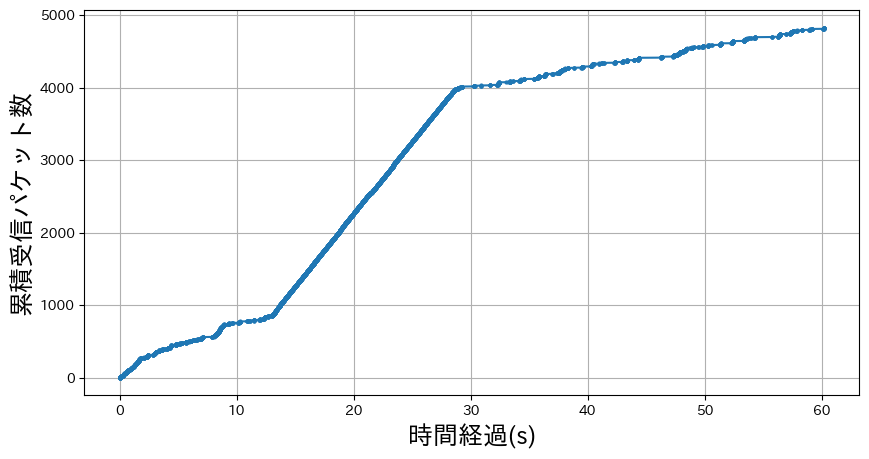

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np  # 目盛り調整のために追加

# 読み込むCSVファイルのリスト（必要に応じてファイル名を変更）
csv_files = [
    # TCP
    # "20250620_072000.csv", #bbr
    # "20250620_072100.csv" ,#bbr
    # "20250529_100350.csv", #reno
    # "20250529_100520.csv" , #cubic

    # UDP20
    # "20250529_100725.csv",
    # "20250529_100858.csv",
    # "20250529_101033.csv",
    # "20250529_160835.csv",
    # "20250529_161010.csv"

    # UDP30
    # "20250529_161140.csv",
    # "20250529_161245.csv",
    # "20250529_161345.csv",
    # "20250529_161435.csv",
    # "20250529_161530.csv"

    # UDP40
    # "20250529_101320.csv",
    # "20250529_101505.csv",
    # "20250529_101610.csv",
    # "20250529_101725.csv",
    # "20250529_161625.csv"

    # UDP50
    # "20250529_161815.csv",
    # "20250529_161915.csv",
    # "20250529_162000.csv",
    # "20250529_162050.csv",
    # "20250529_162140.csv"

    # UDP60
    # "20250529_101840.csv",
    # "20250529_101935.csv",
    # "20250529_102030.csv",
    # "20250529_162320.csv",
    # "20250529_162420.csv"

    # cubic 20Mbps
    # "20250529_164000.csv"

    # 60Mバックグラウンド負荷
    # 10M
    # "20250620_063800.csv",
    # "20250620_064000.csv",
    # "20250620_064200.csv",
    # "20250620_064230.csv",
    # "20250620_064330.csv"
    # 20M
    # "20250620_064500.csv",
    # "20250620_064600.csv",
    # "20250620_064700.csv",
    # "20250620_064800.csv",
    # "20250620_064900.csv"
    # 30M
    # "20250620_065000.csv",
    # "20250620_065100.csv",
    # "20250620_065200.csv",
    # "20250620_065300.csv",
    # "20250620_065400.csv"
    # 40M
    # "20250620_065500.csv",
    # "20250620_065600.csv",
    # "20250620_065700.csv",
    # "20250620_065740.csv",
    # "20250620_065900.csv"
    # # 50M
    # "20250620_070000.csv",
    # "20250620_070100.csv",
    # "20250620_070200.csv",
    # "20250620_070300.csv",
    # "20250620_070330.csv"
    # 60M
    # "20250620_070400.csv",
    # "20250620_070530.csv",
    # "20250620_070600.csv",
    # "20250620_070700.csv",
    # "20250620_070730.csv"


   # 60M
    # "20250620_071600.csv",
    # "20250620_071700.csv",

# CU
    # "test1.csv"
    # "capture_log_CU_20250818_1520.csv"

# 9/12
    # "20250912_010300.csv",
    # "capture_20250912_010232.csv",
#     "20250912_011210.csv",
#     "20250912_011400.csv"

    # "20251031_062300_CUmerge.csv"
    # "20251031_062300.csv",
    # "20251031_070340.csv",
    "20251031_070325_CUmerge_partial.csv"
]





# 各ファイルのプロット用ラベル
labels = ["1回目", "2回目", "3回目", "4回目", "5回目"]
# labels = ["bbr","reno", "cubic"]
# labels = ["1回目"]
# labels = ["2回目"]
# labels = ["3回目"]


# グラフの作成
plt.figure(figsize=(10, 5))

for file, label in zip(csv_files, labels):
    # CSVファイルの読み込み
    df = pd.read_csv(file)

    # "No." を 1 から始まる連番に変更
    df["No."] = range(1, len(df) + 1)

    # "Time" データを 0 秒から始まるように調整
    df["Time"] = df["Time"] - df["Time"].min()

    # 停止している0~5sのデータを削除
    # df = df[df["Time"] > 5]
    # df["Time"] = df["Time"] - 5

    # データのプロット
    plt.plot(df["Time"], df["No."], marker="o", linestyle="-", markersize=2, label=label, )


# 横軸の目盛りを 0.5 秒間隔で設定（ラベルは斜めに表示）
# plt.xticks(np.arange(12.5, 15.5, 0.25), rotation=45, ha="right")

# グラフの設定
# plt.title("時間経過による累積受信パケット数の推移")
plt.xlabel("時間経過(s)", fontsize=18)
plt.ylabel("累積受信パケット数", fontsize=18)
# plt.xlim(8,10)
# plt.ylim(40000,52000)
plt.grid(True)
# plt.legend(fontsize=18)
# plt.rcParams["font.size"] = 25

slope_num = (60000000/(1448*8))
# plt.axline((0, 0), slope=slope_num, color='green', linestyle='--')

# グラフの表示
plt.show()

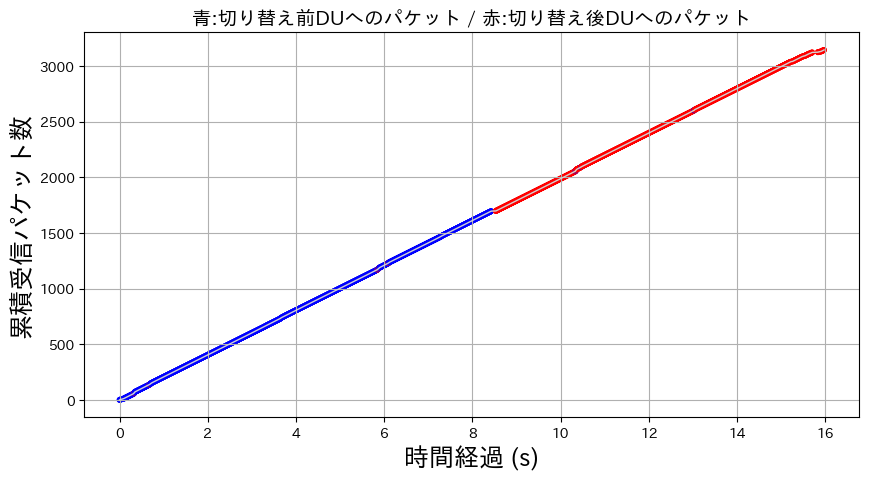

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np

# CSVファイルリスト
csv_files = ["20251031_070325_CUmerge_partial.csv"]

# グラフ作成
plt.figure(figsize=(10, 5))

for file in csv_files:
    df = pd.read_csv(file)

    # No.を連番に、Timeを0基準に
    df["No."] = range(1, len(df) + 1)
    df["Time"] = df["Time"] - df["Time"].min()

    # カラーマップ設定（Sourceに応じて色分け）
    colors = df["Source"].map({
        "169.254.1.22": "blue",
        "169.254.1.21": "red"
    }).fillna("gray")  # それ以外は灰色

    # 折れ線をまず描く（線は共通色でOK）
    plt.plot(df["Time"], df["No."], color="lightgray", linewidth=1)

    # 各点をSourceごとに色付け
    plt.scatter(df["Time"], df["No."], c=colors, s=10)

# 軸やラベル
plt.xlabel("時間経過 (s)", fontsize=18)
plt.ylabel("累積受信パケット数", fontsize=18)
# plt.xlim(21,22)
# plt.ylim(2400,2800)
plt.grid(True)
plt.title("青:切り替え前DUへのパケット / 赤:切り替え後DUへのパケット", fontsize=14)

plt.show()


# ③SS-RSRP、SS-SINRのグラフ出力

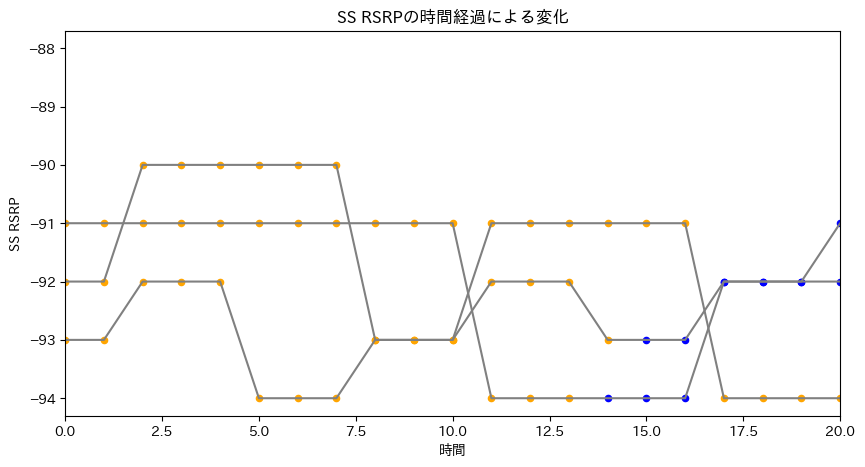

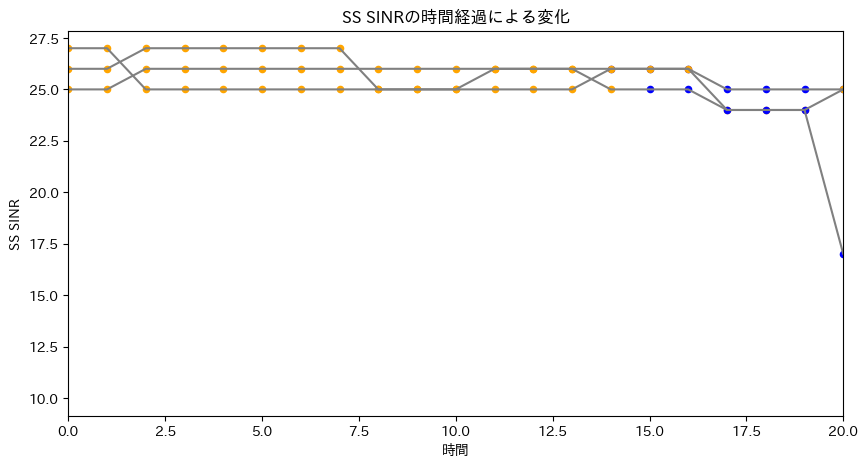

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates

# 読み込むCSVファイルのリスト（適宜ファイル名を変更してください）
# csv_files = [
#     '2025_0206_200850.csv',
#     '2025_0206_200945.csv',
#     '2025_0206_201030.csv'
# ]
csv_files = [ #DU2>>>1
    '0209174720.csv',
    '0209174850.csv',
    '0209175010.csv'
]
csv_files = [ #DU#1>>>2
    '0209174815.csv',
    '0209174920.csv',
    '0209175100.csv'
]
# csv_files = [ #DU3>>>2
#     # '0209175540.csv',
#     '0209175630.csv',
#     '0209175720.csv'
# ]

csv_files = [ #DU3>>>2
    'intraDU2DU1_denpa_1.csv',
    'intraDU2DU1_denpa_2.csv',
    'intraDU2DU1_denpa_3.csv'
]

# 各データのプロット用ラベル（ファイルごとに1回目、2回目、3回目と表示）
labels = ['1回目', '2回目', '3回目']

# カラー設定：PCI==204 の場合は濃い色、PCI==103 の場合は薄い色
color_dark = 'blue'    # 濃い色
color_light = 'orange'  # 薄い色

def plot_metric_overlay(metric):
    """
    指定した metric（例: 'SS RSRP' または 'SS SINR'）について、
    各CSVファイルのデータを散布図（PCIに応じた色）と折れ線グラフを重ねて表示する関数
    """
    plt.figure(figsize=(10, 5))

    # 各ファイルごとに、散布図と折れ線グラフを1回ずつラベルを付与してプロット
    for file, label in zip(csv_files, labels):
        # CSVファイルの読み込み
        df = pd.read_csv(file)
        # "No." を 1から始まる連番として追加
        df["No."] = range(0, len(df))

        # 散布図用：PCI によってデータを分割
        df_dark = df[df["PCI"] == 101]
        df_light = df[df["PCI"] == 102]

        # 折れ線グラフ（全データ）
        plt.plot(df["No."], df[metric],
                 linestyle='-', marker=' ', color='gray',
                 )

        # 散布図（PCI==204）
        if not df_dark.empty:
            plt.scatter(df_dark["No."], df_dark[metric],
                        marker='o', color=color_dark, s=20,
                        )
        # 散布図（PCI==103）
        if not df_light.empty:
            plt.scatter(df_light["No."], df_light[metric],
                        marker='o', color=color_light, s=20,
                        )



    plt.xlabel('時間')
    plt.xlim(0,20)
    # plt.ylim(-95,-70)
    plt.ylabel(metric)
    plt.title(f'{metric}の時間経過による変化')
    plt.show()

# RSRPとSINRそれぞれのグラフを作成して重ねて表示
plot_metric_overlay('SS RSRP')
plot_metric_overlay('SS SINR')


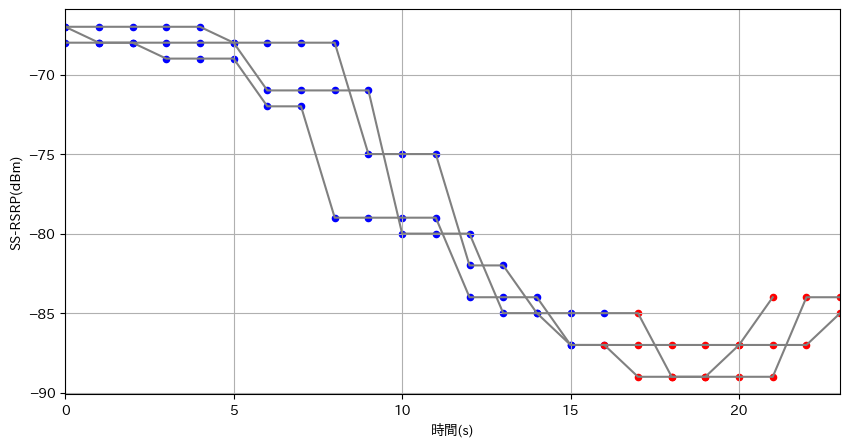

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates

# 読み込むCSVファイルのリスト
csv_files = [
    '2025_0206_200850.csv',
    '2025_0206_200945.csv',
    '2025_0206_201030.csv'
]
# csv_files = [ #DU2>>>1
#     '0209174720.csv',
#     '0209174850.csv',
#     '0209175010.csv'
# ]
# csv_files = [ #DU#1>>>2
#     '0209174815.csv',
#     '0209174920.csv',
#     '0209175100.csv'
# ]
# csv_files = [ #DU3>>>2
#     # '0209175540.csv',
#     '0209175630.csv',
#     '0209175720.csv',
#     '0212175739.csv'
# ]
# 訂正後
csv_files = [ #DU2>>>1
    'intraDU2DU1_denpa_1.csv',
    'intraDU2DU1_denpa_2.csv',
    'intraDU2DU1_denpa_3.csv'
]
# csv_files = [ #DU1>>>2
#     'intraDU2DU2_denpa_1.csv',
#     'intraDU2DU2_denpa_2.csv',
#     'intraDU2DU2_denpa_3.csv'
# ]
csv_files = [ #DU3>>>2
    'denpa_cu2_1.csv',
    'denpa_cu2_2.csv',
    'denpa_cu2_3.csv'
]
# csv_files = [ #DU2>>>3
#     'denpa_cu3_1.csv',
#     'denpa_cu3_2.csv',
#     'denpa_cu3_3.csv'
# ]

# 各データのプロット用ラベル
labels = ['1回目', '2回目', '3回目']

# カラー設定：
color_red = 'blue'    # 濃い色
color_blue = 'red'  # 薄い色
plt.figure(figsize=(10, 5))

# 各ファイルごとに、散布図と折れ線グラフを1回ずつラベルを付与してプロット
for file, label in zip(csv_files, labels):
# CSVファイルの読み込み
  df = pd.read_csv(file)
  # "No." を 1から始まる連番として追加
  df["No."] = range(0, len(df))

  # 散布図用：PCI によってデータを分割
  df_blue = df[df["PCI"] == 102]
  df_red = df[df["PCI"] == 103]


  # 折れ線グラフ（全データ）
  plt.plot(df["No."], df['SS RSRP'],
            linestyle='-', marker=' ', color='gray',
            )

  # 散布図（PCI==204）
  if not df_red.empty:
      plt.scatter(df_red["No."], df_red['SS RSRP'],
                  marker='o', color=color_red, s=20,
                  )
  # 散布図（PCI==103）
  if not df_blue.empty:
      plt.scatter(df_blue["No."], df_blue['SS RSRP'],
                  marker='o', color=color_blue, s=20,
                  )



plt.xlabel('時間(s)')
plt.xlim(0,23)
# plt.ylim(-95,-70)
plt.ylabel('SS-RSRP(dBm)')
# plt.title('SS-の時間経過による変化')
plt.grid(True)
plt.show()


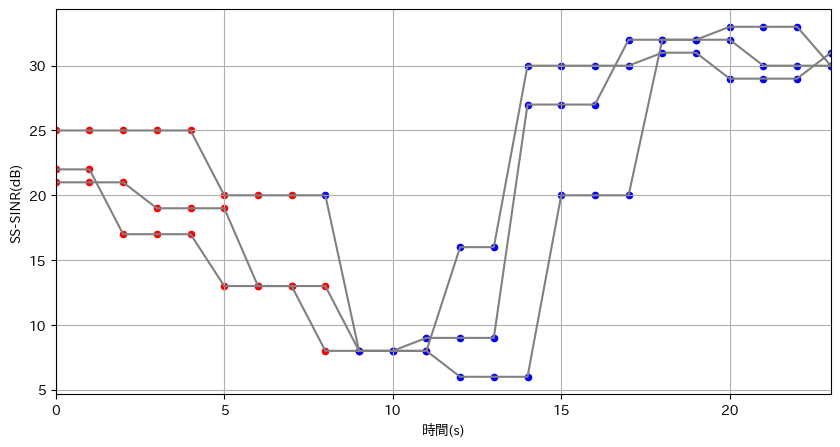

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates

# 読み込むCSVファイルのリスト
csv_files = [
    '2025_0206_200850.csv',
    '2025_0206_200945.csv',
    '2025_0206_201030.csv'
]
# csv_files = [ #DU2>>>1
#     '0209174720.csv',
#     '0209174850.csv',
#     '0209175010.csv'
# ]
# csv_files = [ #DU#1>>>2
#     '0209174815.csv',
#     '0209174920.csv',
#     '0209175100.csv'
# ]
# csv_files = [ #DU3>>>2
#     # '0209175540.csv',
#     '0209175630.csv',
#     '0209175720.csv',
#     '0212175739.csv'
# ]

csv_files = [ #DU3>>>2
    'intraDU2DU1_denpa_1.csv',
    'intraDU2DU1_denpa_2.csv',
    'intraDU2DU1_denpa_3.csv'
]
# csv_files = [ #DU1>>>2
#     'intraDU2DU2_denpa_1.csv',
#     'intraDU2DU2_denpa_2.csv',
#     'intraDU2DU2_denpa_3.csv'
# ]
csv_files = [ #DU3>>>2
    'denpa_cu2_1.csv',
    'denpa_cu2_2.csv',
    'denpa_cu2_3.csv'
]
csv_files = [ #DU2>>>3
    'denpa_cu3_1.csv',
    'denpa_cu3_2.csv',
    'denpa_cu3_3.csv'
]

# 各データのプロット用ラベル
labels = ['1回目', '2回目', '3回目']

# カラー設定：
color_red = 'red'    # 濃い色
color_blue = 'blue'  # 薄い色
plt.figure(figsize=(10, 5))

# 各ファイルごとに、散布図と折れ線グラフを1回ずつラベルを付与してプロット
for file, label in zip(csv_files, labels):
# CSVファイルの読み込み
  df = pd.read_csv(file)
  # "No." を 1から始まる連番として追加
  df["No."] = range(0, len(df))

  # 散布図用：PCI によってデータを分割
  df_red = df[df["PCI"] == 102]
  df_blue = df[df["PCI"] == 103]

  # 折れ線グラフ（全データ）
  plt.plot(df["No."], df['SS SINR'],
            linestyle='-', marker=' ', color='gray',
            )

  if not df_red.empty:
      plt.scatter(df_red["No."], df_red['SS SINR'],
                  marker='o', color=color_red, s=20,
                  )
  if not df_blue.empty:
      plt.scatter(df_blue["No."], df_blue['SS SINR'],
                  marker='o', color=color_blue, s=20,
                  )



plt.xlabel('時間(s)')
plt.xlim(0,23)
# plt.ylim(-95,-70)
plt.ylabel('SS-SINR(dB)')
# plt.title('SS-の時間経過による変化')
plt.grid(True)
plt.show()




# 没

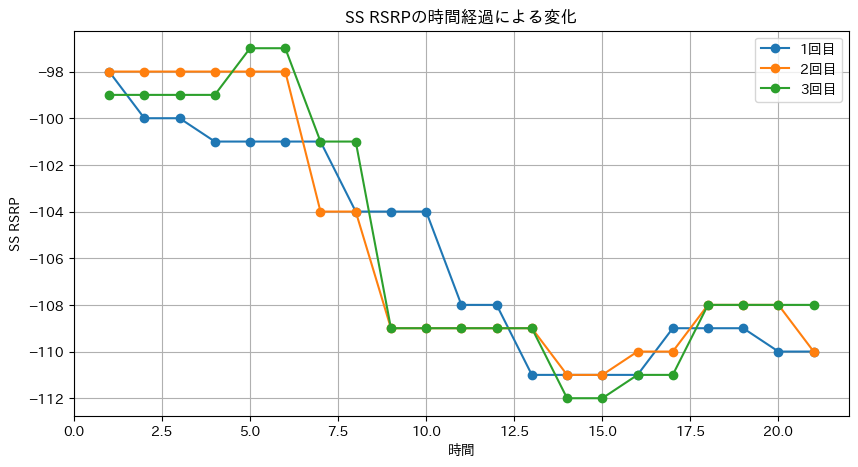

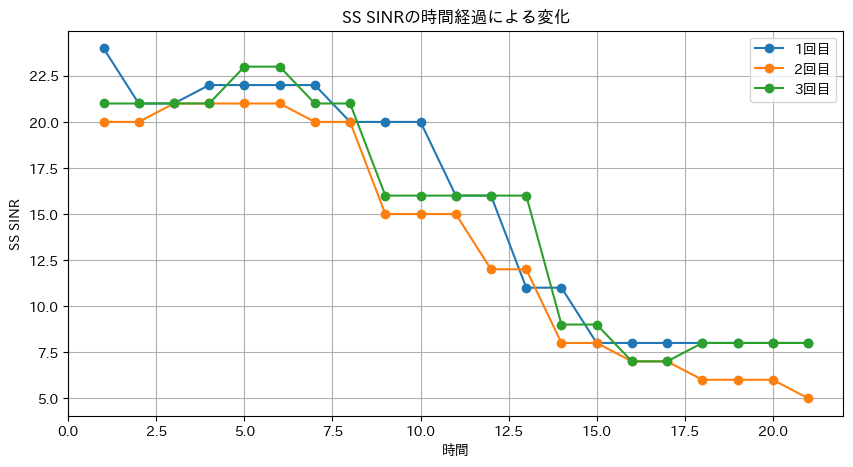

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates

# 読み込むCSVファイルのリスト（適宜ファイル名を変更してください）
csv_files = [
    '2025_0206_200850.csv',
    '2025_0206_200945.csv',
    '2025_0206_201030.csv'
]

# 各データのプロット用ラベル
labels = ['1回目', '2回目', '3回目']



# RSRPとSINRのプロット関数（指定したmetricを各ファイル分重ねてプロット）
def plot_metric(metric):
    plt.figure(figsize=(10, 5))
    for file, label in zip(csv_files, labels):
        # CSVファイルの読み込み
        df = pd.read_csv(file)
        # "No." を 1から始まる連番に変更
        df["No."] = range(1, len(df) + 1)
        # プロット
        plt.plot(df["No."], df[metric], marker='o', linestyle='-', label=label)

    # 軸ラベルとタイトルの設定
    plt.xlabel('時間')
    plt.ylabel(metric)
    plt.title(f'{metric}の時間経過による変化')
    plt.legend()
    plt.grid(True)
    plt.show()

# RSRPとSINRのグラフをそれぞれ作成
plot_metric('SS RSRP')
plot_metric('SS SINR')


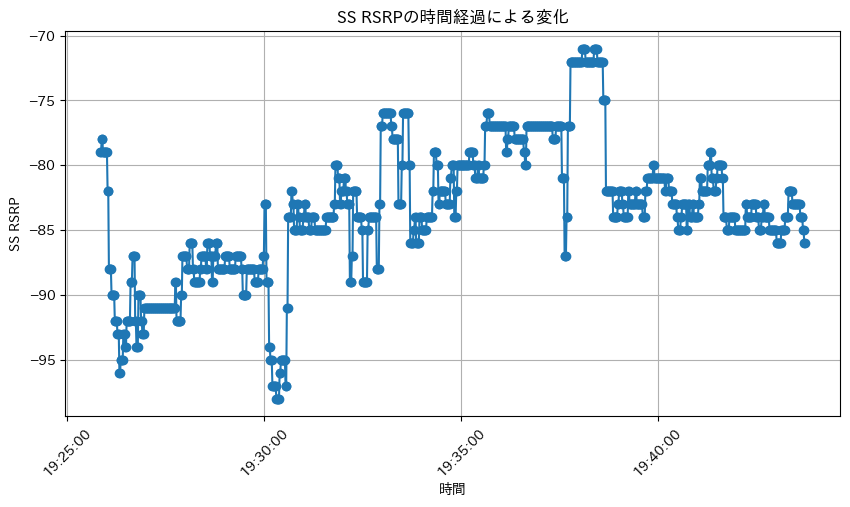

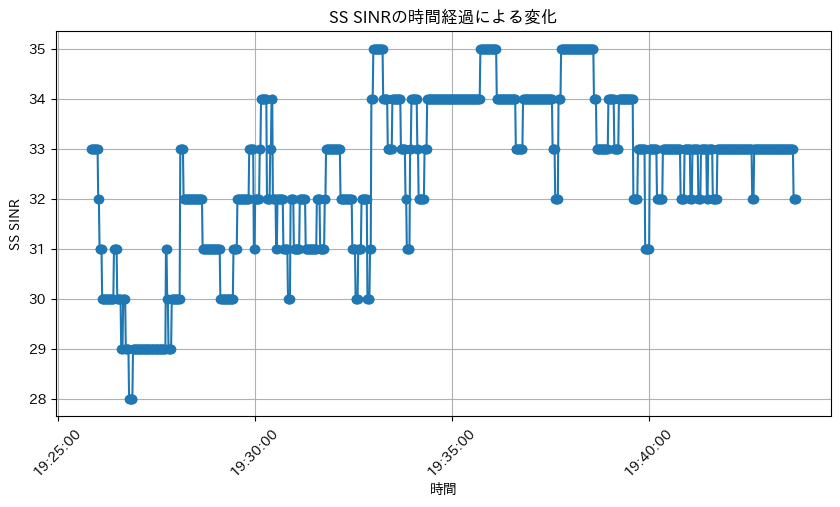

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates

# csvファイルの読み込み
df = pd.read_csv('セミナー室202406071925.csv')

# 'Time' 列を datetime 型に変換
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f')

# RSRPとSINRのプロット関数
def plot_metric(df, metric, start_time=None, end_time=None):
    """
    指定したmetric（RSRPまたはSINR）をプロットする関数
    :param df: データフレーム
    :param metric: 'RSRP' または 'SINR'
    """
    # プロット
    plt.figure(figsize=(10, 5))
    plt.plot(df['Time'], df[metric], marker='o', linestyle='-')

    # 軸ラベルとタイトル
    plt.xlabel('時間')
    plt.ylabel(metric)
    plt.title(f'{metric}の時間経過による変化')

    # x軸のフォーマットを "時間:分:秒" に変更
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

    # x軸ラベルの回転とグリッド
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# 全データでRSRPとSINRをプロット
plot_metric(df, 'SS RSRP')
plot_metric(df, 'SS SINR')




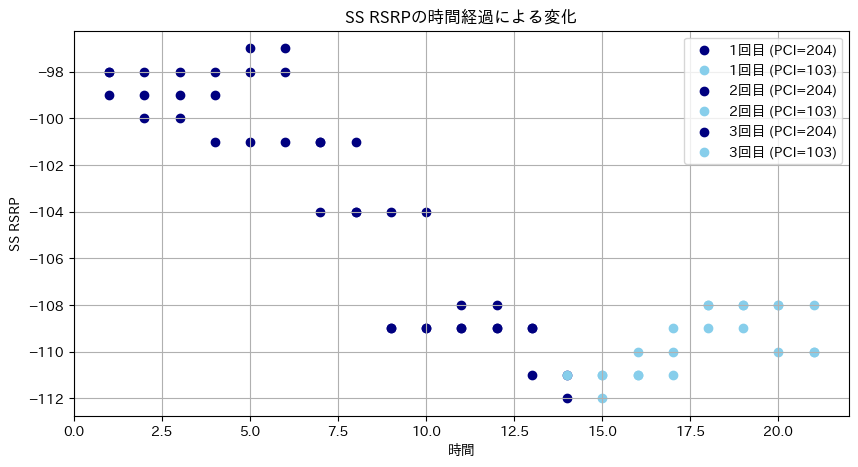

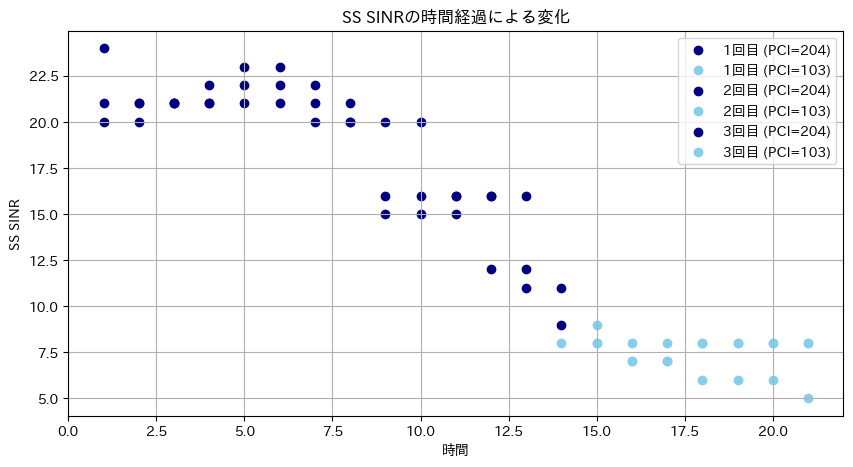

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates

# 読み込むCSVファイルのリスト（適宜ファイル名を変更してください）
csv_files = [
    '2025_0206_200850.csv',
    '2025_0206_200945.csv',
    '2025_0206_201030.csv'
]

# 各データのプロット用ラベル
labels = ['1回目', '2回目', '3回目']

# カラー設定：PCI==204 の場合は濃い色、PCI==103 の場合は薄い色
color_dark = 'navy'    # 濃い色
color_light = 'skyblue'  # 薄い色

def plot_metric(metric):
    """
    指定したmetric（例: 'SS RSRP' または 'SS SINR'）について、各ファイルのデータを散布図でプロットする関数
    PCIが204の場合は濃い色、103の場合は薄い色でプロットします。
    """
    plt.figure(figsize=(10, 5))
    for file, label in zip(csv_files, labels):
        # CSVファイルの読み込み
        df = pd.read_csv(file)
        # "No." を 1 から始まる連番に追加
        df["No."] = range(1, len(df) + 1)

        # PCIの値に応じてデータを分割
        df_dark = df[df["PCI"] == 204]
        df_light = df[df["PCI"] == 103]

        # PCIが204のデータ（濃い色）を散布図としてプロット
        if not df_dark.empty:
            plt.scatter(df_dark["No."], df_dark[metric], marker='o', color=color_dark, label=f'{label} (PCI=204)')
        # PCIが103のデータ（薄い色）を散布図としてプロット
        if not df_light.empty:
            plt.scatter(df_light["No."], df_light[metric], marker='o', color=color_light, label=f'{label} (PCI=103)')

    # 軸ラベルとタイトルの設定
    plt.xlabel('時間')
    plt.ylabel(metric)
    plt.title(f'{metric}の時間経過による変化')
    plt.grid(True)

    # 重複する凡例項目がある場合は一度だけ表示するための工夫
    handles, labels_ = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.show()

# RSRPとSINRそれぞれのグラフを作成して表示
plot_metric('SS RSRP')
plot_metric('SS SINR')


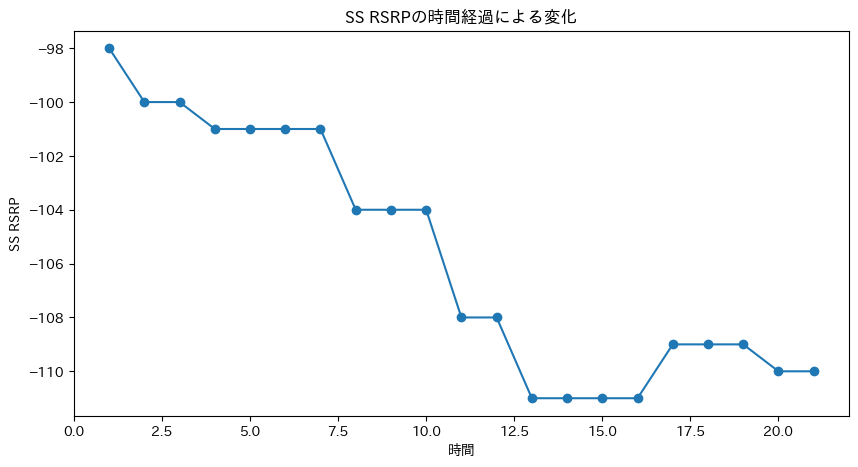

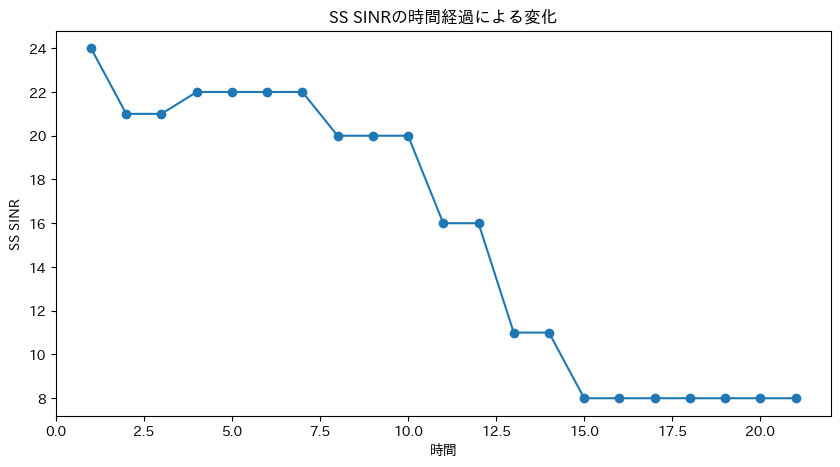

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates

# csvファイルの読み込み
df = pd.read_csv('2025_0206_200850.csv')

# "No." を 追加
df["No."] = range(1, len(df) + 1)

# RSRPとSINRのプロット関数
def plot_metric(df, metric, start_time=None, end_time=None):
    """
    指定したmetric（RSRPまたはSINR）をプロットする関数
    :param df: データフレーム
    :param metric: 'RSRP' または 'SINR'
    """
    # プロット
    plt.figure(figsize=(10, 5))
    plt.plot(df["No."], df[metric], marker='o', linestyle='-')

    # 軸ラベルとタイトル
    plt.xlabel('時間')
    plt.ylabel(metric)
    plt.title(f'{metric}の時間経過による変化')

# 全データでRSRPとSINRをプロット
plot_metric(df, 'SS RSRP')
plot_metric(df, 'SS SINR')




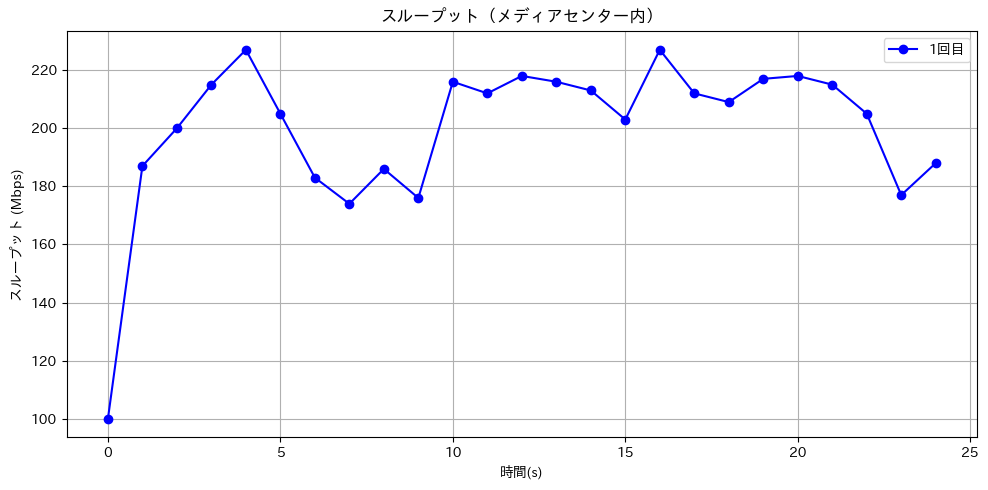

In [ ]:
import math

# JSONデータを読み込む
with open("20250114170023_iperf3.json", 'r') as file:
    data = json.load(file)

# 時間（秒）とスループット（bits_per_second）のデータを抽出
times = []
throughputs = []

for interval in data.get("intervals", []):
    start_time = interval["sum"]["start"]
    bits_per_second = interval["sum"]["bits_per_second"]

    # 秒単位の時間をリストに追加
    times.append(math.floor(start_time))

    # スループットをMbpsに変換し、小数点以下切り捨て
    throughputs.append(math.floor(bits_per_second / 1_000_000))  # Mbpsに変換

# グラフを作成
plt.figure(figsize=(10, 5))
plt.plot(times, throughputs, marker="o", linestyle="-", color="b", label="1回目")
plt.title("スループット（メディアセンター内）")
plt.xlabel("時間(s)")
plt.ylabel("スループット (Mbps)")
plt.grid(True)
plt.legend()

# グラフの表示
plt.tight_layout()
plt.show()

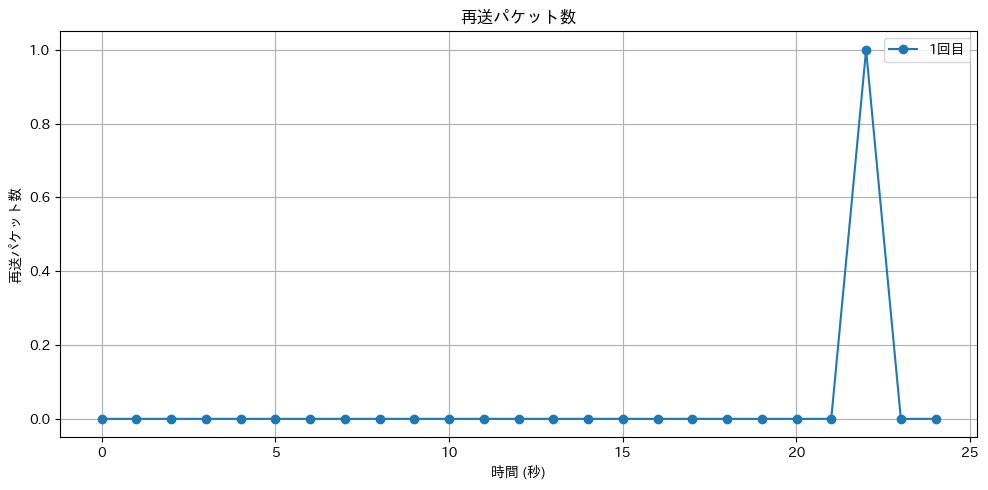

In [ ]:
with open("20250114170023_iperf3.json", "r") as file:
    data = json.load(file)

# 時間（秒）と再送パケット数（retransmits）のデータを抽出
intervals = data["intervals"]
time = [interval["streams"][0]["start"] for interval in intervals]
retransmits = [interval["streams"][0]["retransmits"] for interval in intervals]

# 再送パケット数が None の場合を 0 にする
retransmits = [value if value is not None else 0 for value in retransmits]

# グラフの作成
plt.figure(figsize=(10, 5))
plt.plot(time, retransmits, marker="o", linestyle="-", label="1回目")

# グラフの設定
plt.title("再送パケット数")
plt.xlabel("時間 (秒)")
plt.ylabel("再送パケット数")
plt.grid(True)
plt.legend()

# グラフの表示
plt.tight_layout()
plt.show()

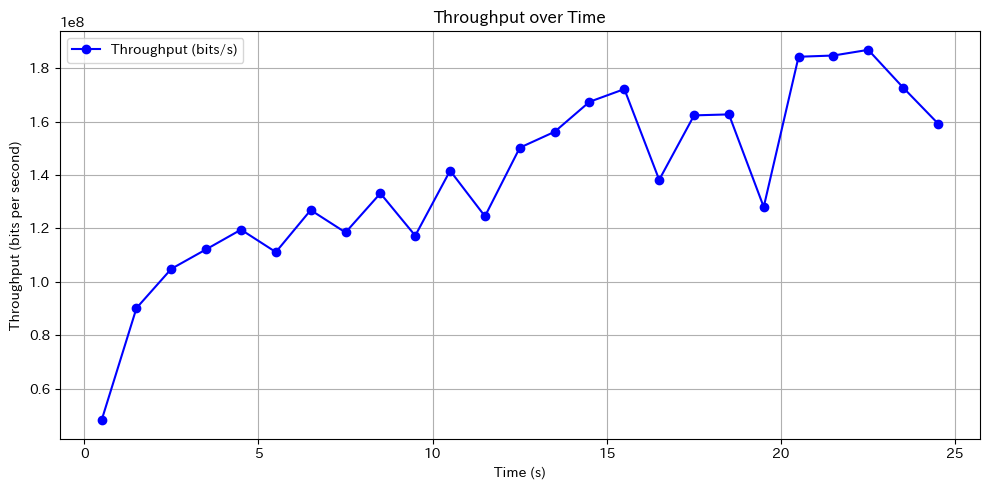

In [ ]:
# JSONデータを読み込む
json_file_path = "20250114171116_iperf3.json"

try:
    # JSONデータを読み込む
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # 時間（秒）とスループット（bits_per_second）のデータを抽出
    times = []
    bit_rates = []

    for interval in data.get('intervals', []):  # intervalsキーが存在するかチェック
        start_time = interval['sum']['start']
        end_time = interval['sum']['end']
        avg_time = (start_time + end_time) / 2
        bit_rate = interval['sum']['bits_per_second']

        times.append(avg_time)
        bit_rates.append(bit_rate)

    # グラフを作成
    plt.figure(figsize=(10, 5))
    plt.plot(times, bit_rates, marker='o', linestyle='-', color='b', label='1回目')
    plt.title('Throughput over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Throughput (bits per second)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: File '{json_file_path}' not found.")
except json.JSONDecodeError:
    print(f"Error: File '{json_file_path}' is not a valid JSON file or is empty.")


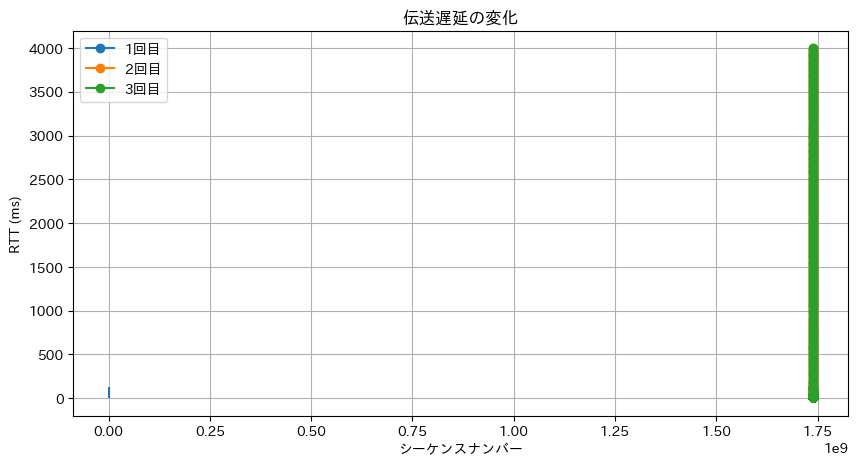

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib


# # IPAフォントを指定
# font_path = "/usr/share/fonts/opentype/ipafont-gothic/IPAGothic.ttf"
# font_prop = fm.FontProperties(fname=font_path)
# plt.rcParams["font.family"] = font_prop.get_name()

# Pythonコード: RTT vs Sequence Number グラフのプロット
import json

# 可視化するデータ
json_files = [
    "20250205203819_ping.json",  # 1回目のデータ
    "20250205211620_ping.json",  # 2回目のデータ
    "20250205211740_ping.json"   # 3回目のデータ
]

# ラベルリスト
labels = ["1回目", "2回目", "3回目"]

# グラフの作成
plt.figure(figsize=(10, 5))

for json_file, label in zip(json_files, labels):
    # JSONファイルの読み込み
    with open(json_file, "r") as file:
        data = json.load(file)

    # responsesからtimestampとtime_msを抽出
    responses = data.get("responses", [])
    timestamp = [entry["timestamp"] for entry in responses if "timestamp" in entry and "time_ms" in entry]
    time_ms = [entry["time_ms"] for entry in responses if "timestamp" in entry and "time_ms" in entry]

    # グラフにプロット
    plt.plot(timestamp, time_ms, marker="o", linestyle="-", label=label)

# グラフの設定
plt.title("伝送遅延の変化")
plt.xlabel("シーケンスナンバー")
plt.ylabel("RTT (ms)")
plt.grid(True)
plt.vlines(130,0,130)
plt.legend()  # 凡例に日本語フォントを適用

# グラフの表示
# plt.tight_layout()
plt.show()


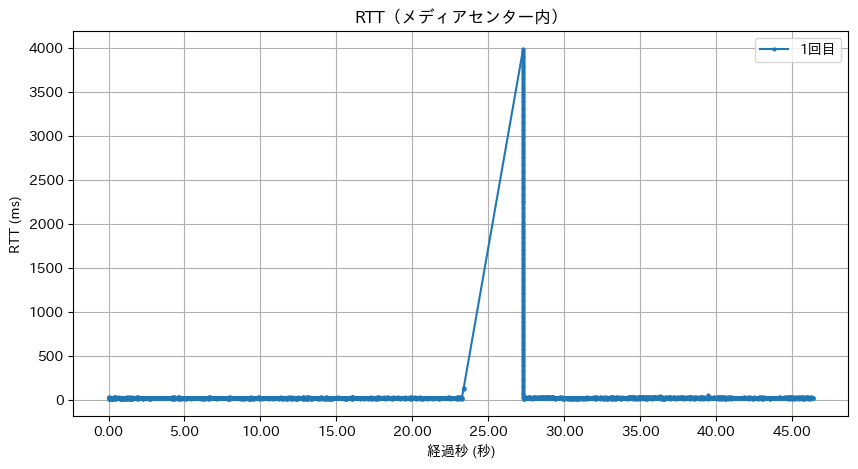

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib
from datetime import datetime, timezone, timedelta

# グラフに表示するJSONファイル（1つのファイルに変更）
json_file = "20250205211740_ping.json"  # ファイル名を指定

# JSONファイルの読み込み
with open(json_file, "r") as file:
    data = json.load(file)

# responsesからタイムスタンプとtime_msを抽出
responses = data.get("responses", [])

# JST（日本標準時）のタイムゾーン設定
jst = timezone(timedelta(hours=9))

# タイムスタンプをdatetimeオブジェクトに変換
# （なお、ここでは各エントリに"timestamp"と"time_ms"が存在する前提です）
timestamps = [
    datetime.fromtimestamp(entry["timestamp"], jst)
    for entry in responses if "timestamp" in entry and "time_ms" in entry
]
time_ms = [
    entry["time_ms"]
    for entry in responses if "timestamp" in entry and "time_ms" in entry
]

# ※ 相対秒表示とするため、最初のタイムスタンプを基準にする
if timestamps:
    t0 = min(timestamps)
    x_seconds = [(t - t0).total_seconds() for t in timestamps]
else:
    x_seconds = []

# グラフの作成
plt.figure(figsize=(10, 5))
plt.plot(x_seconds, time_ms, marker="o", linestyle="-", markersize=2, label="1回目")

# グラフの設定
plt.title("RTT（メディアセンター内）")
plt.xlabel("経過秒 (秒)")
plt.ylabel("RTT (ms)")
plt.grid(True)
plt.legend()

# x軸の目盛り設定：細かい間隔（ここでは0.1秒刻み）で表示し、
# ラベルは小数点以下2桁まで表示（例：0.00, 0.10, 0.20, ...）
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.show()


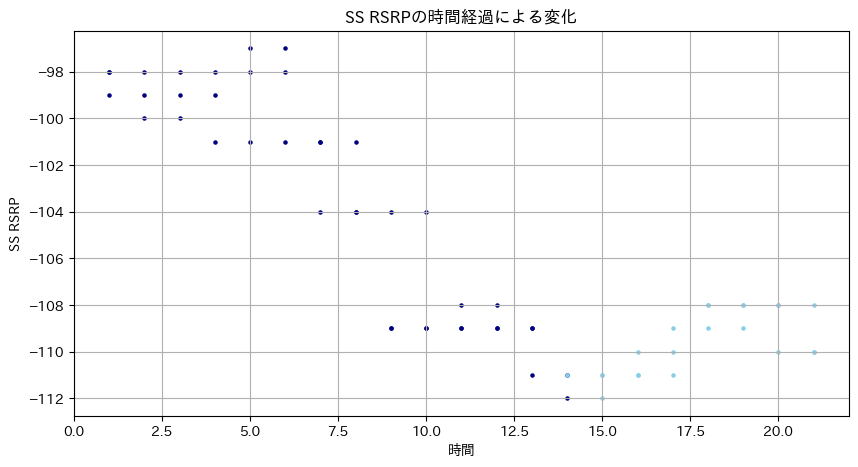

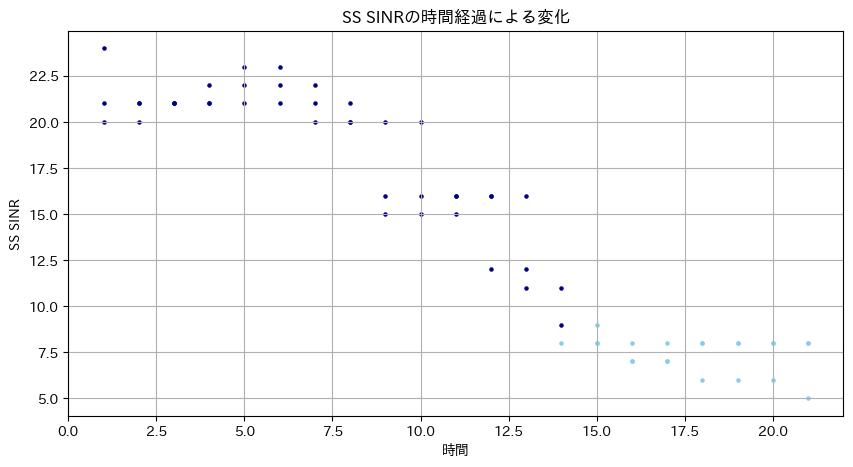

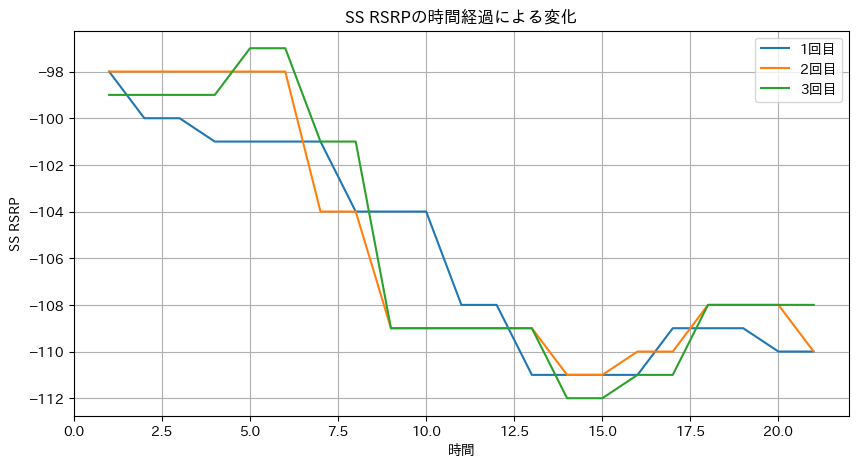

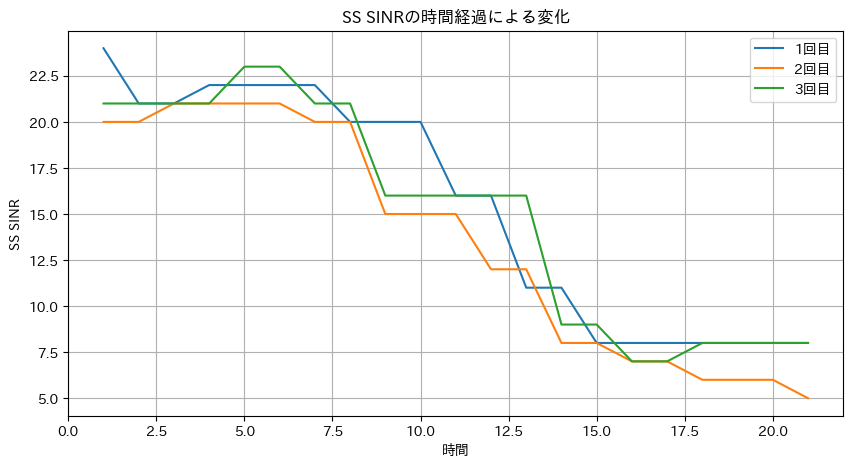

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates

# 読み込むCSVファイルのリスト（適宜ファイル名を変更してください）
csv_files = [
    '2025_0206_200850.csv',
    '2025_0206_200945.csv',
    '2025_0206_201030.csv'
]

# 各データのプロット用ラベル
labels = ['1回目', '2回目', '3回目']

# カラー設定：PCI==204 の場合は濃い色、PCI==103 の場合は薄い色
color_dark = 'navy'    # 濃い色
color_light = 'skyblue'  # 薄い色

def plot_metric1(metric):
    """
    指定したmetric（例: 'SS RSRP' または 'SS SINR'）について、各ファイルのデータを散布図でプロットする関数
    PCIが204の場合は濃い色、103の場合は薄い色でプロットします。
    """
    plt.figure(figsize=(10, 5))
    for file, label in zip(csv_files, labels):
        # CSVファイルの読み込み
        df = pd.read_csv(file)
        # "No." を 1 から始まる連番に追加
        df["No."] = range(1, len(df) + 1)

        # PCIの値に応じてデータを分割
        df_dark = df[df["PCI"] == 204]
        df_light = df[df["PCI"] == 103]

        # PCIが204のデータ（濃い色）を散布図としてプロット
        if not df_dark.empty:
            plt.scatter(df_dark["No."], df_dark[metric], marker='o', color=color_dark, s=5, label=f'{label} (PCI=204)')
        # PCIが103のデータ（薄い色）を散布図としてプロット
        if not df_light.empty:
            plt.scatter(df_light["No."], df_light[metric], marker='o', color=color_light, s=5, label=f'{label} (PCI=103)')

    # 軸ラベルとタイトルの設定
    plt.xlabel('時間')
    plt.ylabel(metric)
    plt.title(f'{metric}の時間経過による変化')
    plt.grid(True)
    plt.show()

# RSRPとSINRそれぞれのグラフを作成して表示
plot_metric1('SS RSRP')
plot_metric1('SS SINR')


# RSRPとSINRのプロット関数（指定したmetricを各ファイル分重ねてプロット）
def plot_metric(metric):
    plt.figure(figsize=(10, 5))
    for file, label in zip(csv_files, labels):
        # CSVファイルの読み込み
        df = pd.read_csv(file)
        # "No." を 1から始まる連番に変更
        df["No."] = range(1, len(df) + 1)
        # プロット
        plt.plot(df["No."], df[metric], marker=' ', linestyle='-', label=label)

    # 軸ラベルとタイトルの設定
    plt.xlabel('時間')
    plt.ylabel(metric)
    plt.title(f'{metric}の時間経過による変化')
    plt.legend()
    plt.grid(True)
    plt.show()

# RSRPとSINRのグラフをそれぞれ作成
plot_metric('SS RSRP')
plot_metric('SS SINR')


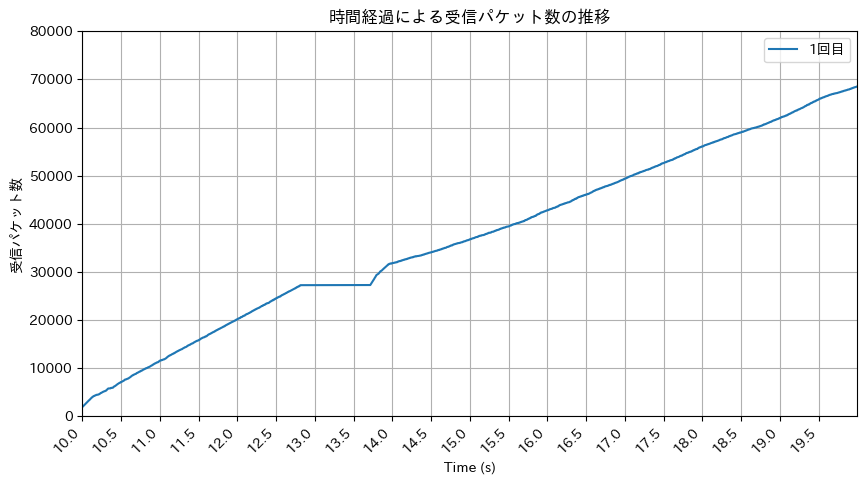

In [ ]:
!pip install japanize-matplotlib

import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np  # 目盛り調整のために追加

# CSVファイルの読み込み
csv_file = "iperf3_DL_intraCU_01292320.csv"  # ファイル名を適宜変更してください
df = pd.read_csv(csv_file)

# "No." を 1 から始まる連番に変更
df["No."] = range(1, len(df) + 1)

# グラフの作成
plt.figure(figsize=(10, 5))
# plt.plot(df["Time"], df["No."], marker="o", linestyle="-", label="パケットNo.")
plt.plot(df["Time"], df["No."], marker=" ", linestyle="-", markersize=0.5, label="1回目")  # 点を小さくする

# **横軸の範囲を 12 ～ 15 に設定**
plt.xlim(10, 20)

# **横軸の目盛りを細かく設定（0.5秒間隔）**
plt.xticks(np.arange(10, 20, 0.5), rotation=45, ha="right")  # 0.5秒ごとにし、ラベルを斜めに

# **y軸の範囲を適切に調整**
plt.ylim(0,80000)

# グラフの設定
plt.title("時間経過による受信パケット数の推移")
plt.xlabel("Time (s)")
plt.ylabel("受信パケット数")
plt.grid(True)
plt.legend()

# グラフの表示
plt.show()

# 分布図・棒グラフ

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36884 (\N{CJK UNIFIED IDEOGRAPH-9014}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32118 (\N{CJK UNIFIED IDEOGRAPH-7D76}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


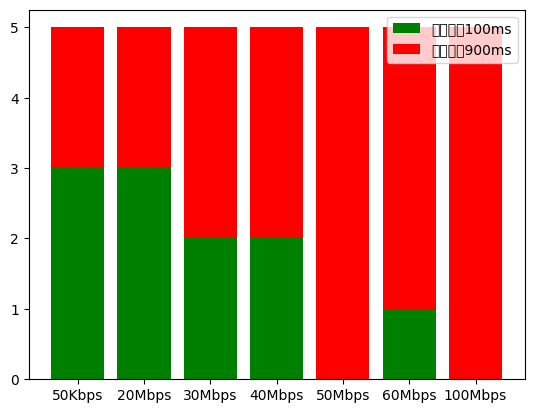

In [ ]:
# !pip install numpy
import numpy as np
import matplotlib.pyplot as plt

labels = ["50Kbps","20Mbps","30Mbps","40Mbps","50Mbps","60Mbps", "100Mbps"]
HO_100ms = np.array([5,5,4,4,2,3,2])-2
HO_900ms = np.array([0,0,1,1,3,2,3])+2
left = np.array([1,2,3,4,5,6,7])

plt.bar(left, HO_100ms, tick_label = labels, label="途絶時間100ms", color="green")
plt.bar(left, HO_900ms, label="途絶時間900ms", color="red", bottom=HO_100ms)
plt.legend()
plt.show()



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib

bandwidths = ['10Mbps', '20Mbps', '30Mbps', '40Mbps', '50Mbps', '60Mbps']
# bandwidths = ['20Mbps']

count_100 = [5,5,4,4,2,3]
count_900 = [0,0,1,1,3,2]

# count_100 = [0,2,0,0,0,0]
# count_900 = [0,0,0,0,0,0]

x = np.arange(len(bandwidths))  # x軸の位置
width = 0.25  # 棒の幅

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, count_100, width, label='100ms', color='skyblue')
bars2 = ax.bar(x + width/2, count_900, width, label='900ms', color='salmon')

# ラベル・タイトル設定
ax.set_xlabel('帯域', fontsize=12)
ax.set_ylabel('出現回数', fontsize=12)
ax.set_title('帯域ごとの通信途絶時間（ハンドオーバー時）', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(bandwidths)
ax.legend()
ax.set_ylim(0, 5)

# グリッドと値ラベルの追加
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3ポイント上
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'japanize_matplotlib'

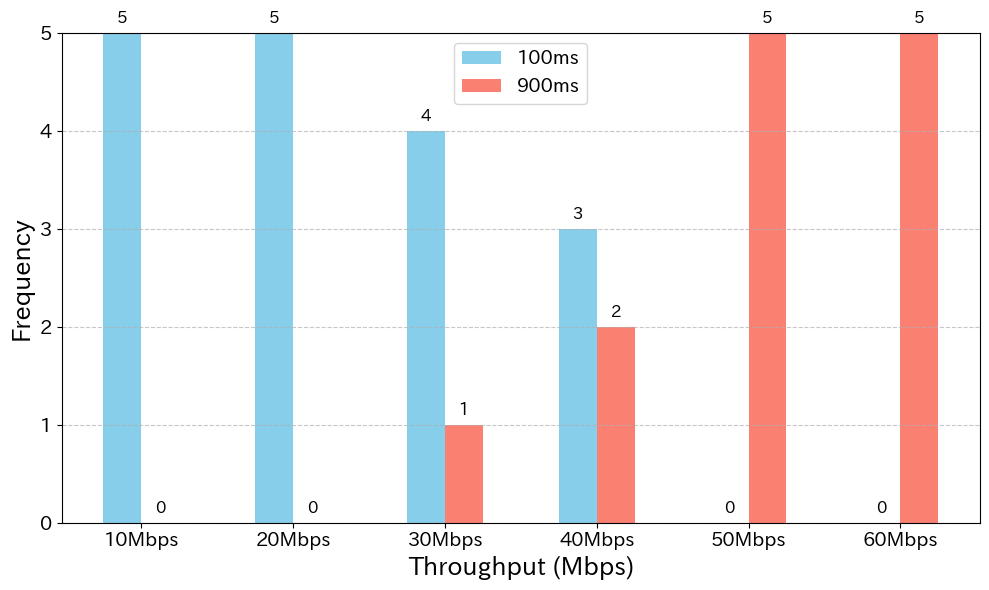

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib

bandwidths = ['10Mbps', '20Mbps', '30Mbps', '40Mbps', '50Mbps', '60Mbps']
# bandwidths = ['20Mbps']

count_100 = [5,5,4,3,0,0]
count_900 = [0,0,1,2,5,5]

# count_100 = [5,5,4,4,2,3]
# count_900 = [0,0,1,1,3,2]

x = np.arange(len(bandwidths))  # x軸の位置
width = 0.25  # 棒の幅

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, count_100, width, label='100ms', color='skyblue')
bars2 = ax.bar(x + width/2, count_900, width, label='900ms', color='salmon')

# ラベル・タイトル設定（文字大きめ）
# ax.set_xlabel('帯域', fontsize=18)
# ax.set_ylabel('出現回数', fontsize=18)
ax.set_xlabel('Throughput (Mbps)', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
# ax.set_title('ハンドオーバー時の通信途絶時間', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(bandwidths, fontsize=16)
ax.legend(fontsize=14)
ax.set_ylim(0, 5)

# 軸の目盛り文字サイズ
ax.tick_params(axis='both', which='major', labelsize=14)

# グリッドと値ラベルの追加
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # ちょっと余裕をもたせる
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=12)

plt.tight_layout()
plt.show()


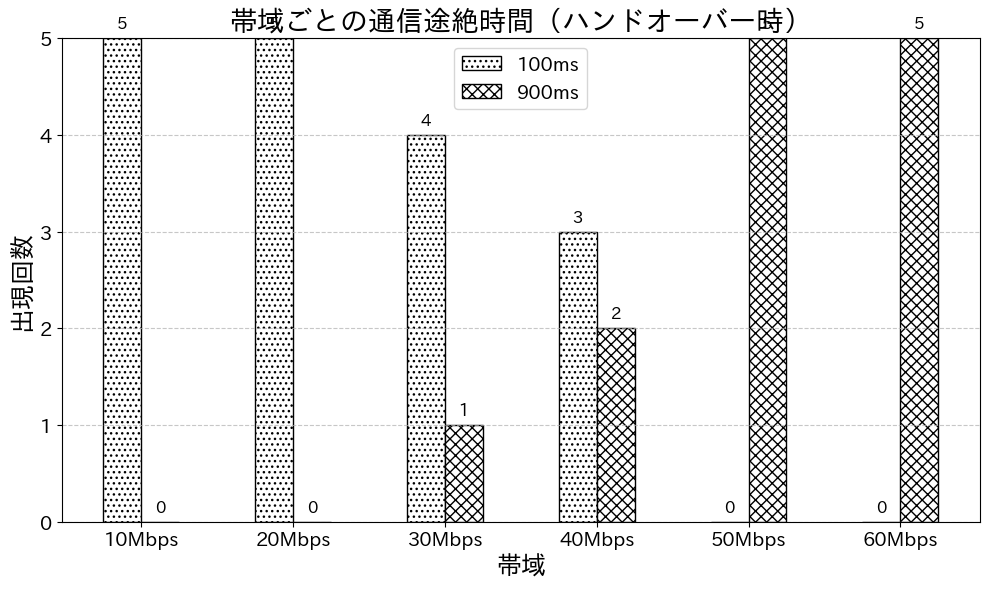

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib

bandwidths = ['10Mbps', '20Mbps', '30Mbps', '40Mbps', '50Mbps', '60Mbps']

count_100 = [5,5,4,4,2,3]
count_900 = [0,0,1,1,3,2]

count_100 = [5,5,4,3,0,0]
count_900 = [0,0,1,2,5,5]

x = np.arange(len(bandwidths))  # x軸の位置
width = 0.25  # 棒の幅

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, count_100, width, label='100ms',
               color='white', edgecolor='black', hatch='...')
bars2 = ax.bar(x + width/2, count_900, width, label='900ms',
               color='white', edgecolor='black', hatch='xxx')

# ラベル・タイトル設定
ax.set_xlabel('帯域', fontsize=18)
ax.set_ylabel('出現回数', fontsize=18)
ax.set_title('帯域ごとの通信途絶時間（ハンドオーバー時）', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(bandwidths, fontsize=16)
ax.legend(fontsize=14)
ax.set_ylim(0, 5)

# 軸の目盛り文字サイズ
ax.tick_params(axis='both', which='major', labelsize=14)

# グリッドと値ラベルの追加
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=12)

plt.tight_layout()
plt.show()


# CUのリソース使用率可視化

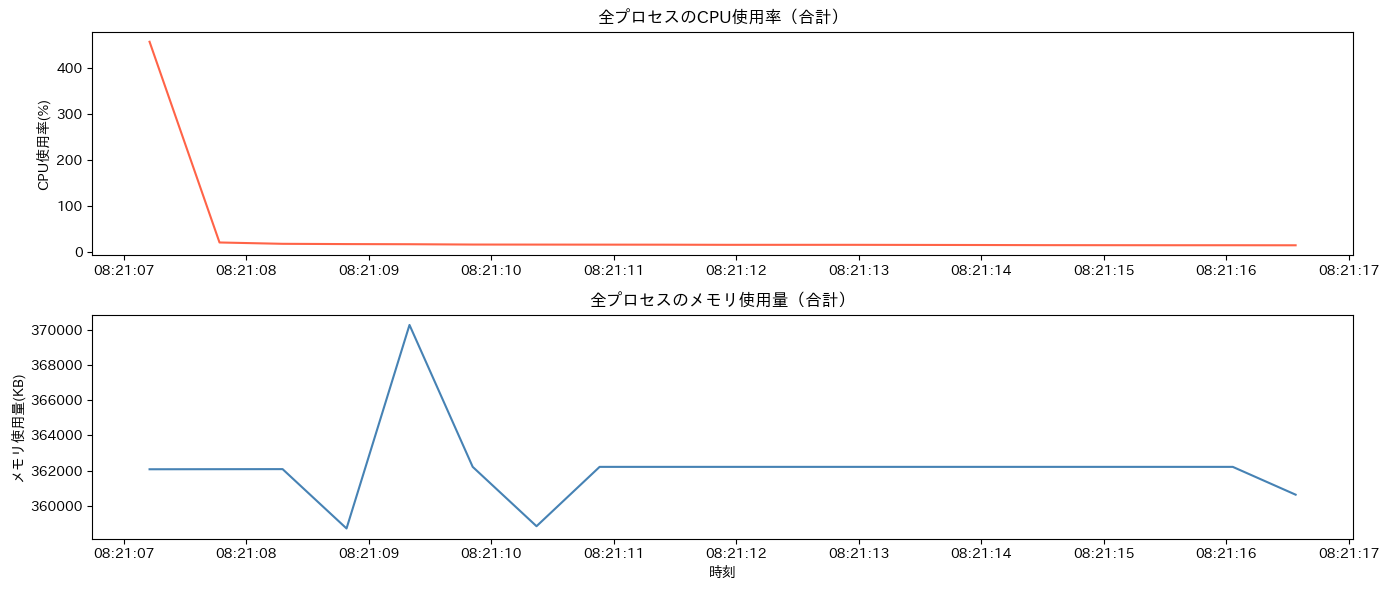

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語対応（任意）
from datetime import datetime

# CSVファイルのパス（必要に応じて変更）
csv_file = "process_log_CU_20250804_0821.csv"

# CSV読み込み
df = pd.read_csv(csv_file)

# タイムスタンプをdatetime型に変換
df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S.%f")

# CPUとメモリを数値型に変換（念のため）
df["CPU_Usage(%)"] = pd.to_numeric(df["CPU_Usage(%)"], errors="coerce")
df["Memory_Usage(KB)"] = pd.to_numeric(df["Memory_Usage(KB)"], errors="coerce")

# タイムスタンプごとにCPUとメモリを合計
agg_df = df.groupby("Time").sum().reset_index()

# プロット設定
plt.figure(figsize=(14, 6))

# グラフ1: CPU使用率（全プロセス合計）
plt.subplot(2, 1, 1)
plt.plot(agg_df["Time"], agg_df["CPU_Usage(%)"], label="CPU使用率(%)", color="tomato")
plt.ylabel("CPU使用率(%)")
plt.title("全プロセスのCPU使用率（合計）")

# グラフ2: メモリ使用量（全プロセス合計）
plt.subplot(2, 1, 2)
plt.plot(agg_df["Time"], agg_df["Memory_Usage(KB)"], label="メモリ使用量(KB)", color="steelblue")
plt.ylabel("メモリ使用量(KB)")
plt.xlabel("時刻")
plt.title("全プロセスのメモリ使用量（合計）")

plt.tight_layout()
plt.show()


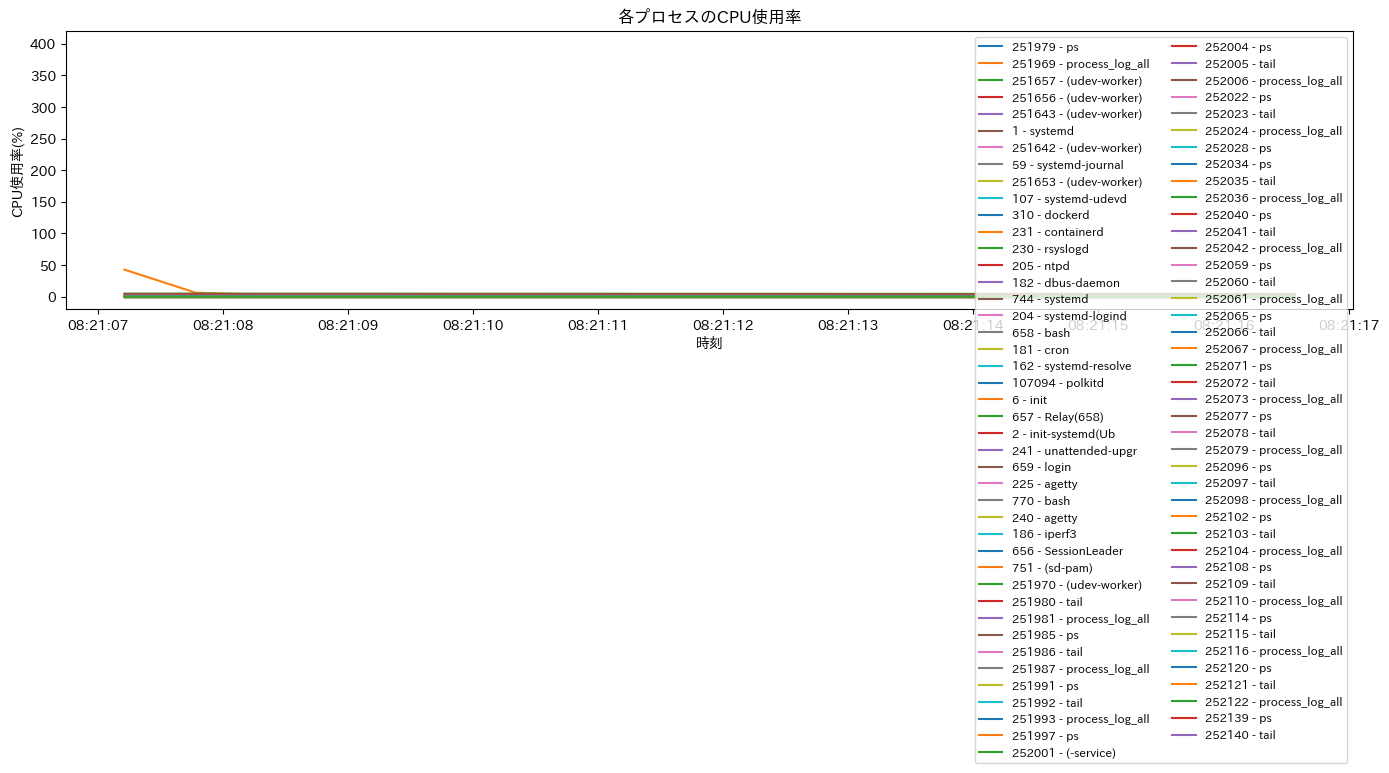

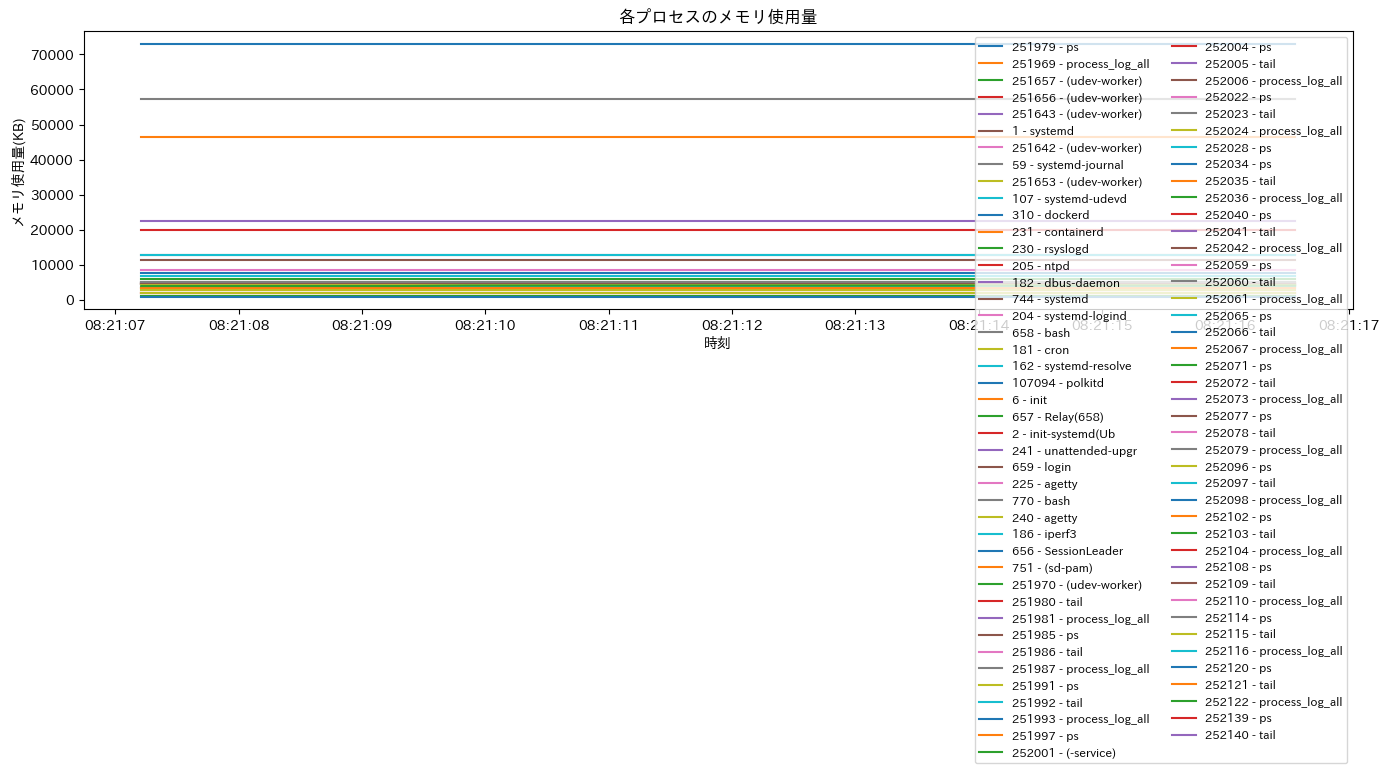

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib  # 任意、日本語コマンド名などの対応用

# CSVファイル名（必要に応じて変更）
csv_file = "process_log_CU_20250804_0821.csv"

# CSV読み込み
df = pd.read_csv(csv_file)

# 時刻をdatetime型に変換
df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S.%f")

# 数値変換（文字列だった場合に備える）
df["CPU_Usage(%)"] = pd.to_numeric(df["CPU_Usage(%)"], errors="coerce")
df["Memory_Usage(KB)"] = pd.to_numeric(df["Memory_Usage(KB)"], errors="coerce")

# PIDとコマンド名を組み合わせて一意なキーに
df["Process_ID"] = df["PID"].astype(str) + " - " + df["Command"]

# CPU使用率グラフ
plt.figure(figsize=(14, 6))
for proc in df["Process_ID"].unique():
    proc_df = df[df["Process_ID"] == proc]
    plt.plot(proc_df["Time"], proc_df["CPU_Usage(%)"], label=proc)

plt.xlabel("時刻")
plt.ylabel("CPU使用率(%)")
plt.title("各プロセスのCPU使用率")
plt.legend(loc="upper right", fontsize="small", ncol=2)  # 凡例が多い場合は調整
plt.tight_layout()
plt.show()

# メモリ使用量グラフ
plt.figure(figsize=(14, 6))
for proc in df["Process_ID"].unique():
    proc_df = df[df["Process_ID"] == proc]
    plt.plot(proc_df["Time"], proc_df["Memory_Usage(KB)"], label=proc)

plt.xlabel("時刻")
plt.ylabel("メモリ使用量(KB)")
plt.title("各プロセスのメモリ使用量")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
import nest_asyncio
nest_asyncio.apply()


import pyshark
import matplotlib.pyplot as plt

cap = pyshark.FileCapture(
    "20250620_072000_part.pcap",
    display_filter="tcp",
    keep_packets=True  # 全部メモリに保持
)

# 先に全パケットをロード（非同期問題を避ける）
cap.load_packets()

times = []
windows = []

for pkt in cap:
    try:
        t = float(pkt.sniff_timestamp)
        w = int(pkt.tcp.window_size_value)
        times.append(t)
        windows.append(w)
    except AttributeError:
        continue

cap.close()

plt.figure(figsize=(10,5))
plt.plot(times, windows, marker=".", linestyle="-")
plt.xlabel("Time (s)")
plt.ylabel("TCP Window Size")
plt.title("TCP Window Size over Time")
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'pyshark'